In [1]:
!pip install  mediapipe==0.10.13 opencv-python torch torchvision pandas scikit-learn efficientnet_pytorch tqdm


In [2]:
!pip install -q gdown

In [5]:
import os

count = sum(len(files) for _, _, files in os.walk("dataset/train"))
print("Total extracted files:", count)


Total extracted files: 75


In [6]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("GPU count:", torch.cuda.device_count())

if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))


CUDA available: True
CUDA version: 12.8
GPU count: 1
GPU name: NVIDIA A100-SXM4-40GB MIG 3g.20gb


In [5]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
import mediapipe as mp
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as T
import torchvision.models as models
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

DATASET_DIR = "./dataset/train"         
LABELS_FILE = os.path.join(DATASET_DIR, "labels_train.xlsx")
PROCESSED_DIR = "./processed_faces"
RESULTS_DIR = "./results"

FRAMES_PER_VIDEO = 20
FACE_SIZE = 224
BATCH_SIZE = 4
SEED = 42

os.makedirs(PROCESSED_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

torch.manual_seed(SEED)
np.random.seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_memory_allocated(0)/1e9:.1f}GB / {torch.cuda.get_total_memory(0)/1e9:.1f}GB" if hasattr(torch.cuda, 'get_total_memory') else "")

Device: cuda
GPU: NVIDIA A100-SXM4-40GB MIG 3g.20gb



In [10]:
!pip install openpyxl

In [6]:
df_labels = pd.read_excel(LABELS_FILE)
print(f"Label file columns: {df_labels.columns.tolist()}")
print(f"Total entries: {len(df_labels)}")
print(f"\nFirst 10 rows:")
print(df_labels.head(10))
print(f"\nLabel distribution (original):")
print(df_labels['label'].value_counts().sort_index())

video_paths = []
missing_videos = []

for _, row in df_labels.iterrows():
    vname = row['video']
    vpath = os.path.join(DATASET_DIR, vname)
    if os.path.exists(vpath):
        video_paths.append(vpath)
    else:
        found = glob.glob(os.path.join(DATASET_DIR, '**', vname), recursive=True)
        if found:
            video_paths.append(found[0])
        else:
            missing_videos.append(vname)
            video_paths.append(None)

df_labels['video_path'] = video_paths

if missing_videos:
    print(f"\nWARNING: {len(missing_videos)} videos not found:")
    for mv in missing_videos:
        print(f"  - {mv}")

df_labels = df_labels[df_labels['video_path'].notna()].reset_index(drop=True)
print(f"\nUsable videos: {len(df_labels)}")


df_labels['binary_label'] = df_labels['label'].apply(lambda x: 0 if x <= 0.33 else 1)

label_to_multiclass = {0.0: 0, 0.33: 1, 0.66: 2, 1.0: 3}
df_labels['multi_label'] = df_labels['label'].map(label_to_multiclass)

print(f"\nBinary label distribution:")
print(df_labels['binary_label'].value_counts().sort_index())
print(f"\nMulti-class label distribution:")
print(df_labels['multi_label'].value_counts().sort_index())

Label file columns: ['video', 'label']
Total entries: 74

First 10 rows:
                    video  label
0    subject_10_Vid_6.avi   0.66
1    subject_11_Vid_6.MP4   1.00
2    subject_12_Vid_6.MP4   0.00
3    subject_15_Vid_6.avi   0.66
4    subject_16_Vid_6.MP4   0.33
5   subject_18_Vid_6.webm   0.33
6     subject_1_Vid_5.avi   1.00
7    subject_20_Vid_2.avi   0.66
8  subject_20_Vid_5_2.avi   1.00
9    subject_20_Vid_6.avi   0.66

Label distribution (original):
label
0.00     7
0.33    23
0.66    22
1.00    22
Name: count, dtype: int64

Usable videos: 74

Binary label distribution:
binary_label
0    30
1    44
Name: count, dtype: int64

Multi-class label distribution:
multi_label
0     7
1    23
2    22
3    22
Name: count, dtype: int64


In [13]:
import mediapipe as mp
mp_face_detection = mp.solutions.face_detection
face_detector = mp_face_detection.FaceDetection(
    model_selection=1,
    min_detection_confidence=0.5
)


def extract_face_frames(video_path, n_frames=FRAMES_PER_VIDEO, face_size=FACE_SIZE):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"  Cannot open: {video_path}")
        return None

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames < 1:
        cap.release()
        return None

    frame_indices = np.linspace(0, total_frames - 1, n_frames, dtype=int)
    faces = []

    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret or frame is None:
            continue

        h, w = frame.shape[:2]
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        face_crop = None
        results = face_detector.process(rgb)

        if results.detections:
            det = results.detections[0]
            bbox = det.location_data.relative_bounding_box

            x1 = int(bbox.xmin * w)
            y1 = int(bbox.ymin * h)
            bw = int(bbox.width * w)
            bh = int(bbox.height * h)

            # 20% margin
            mx, my = int(0.2 * bw), int(0.2 * bh)
            x1 = max(0, x1 - mx)
            y1 = max(0, y1 - my)
            x2 = min(w, x1 + bw + 2 * mx)
            y2 = min(h, y1 + bh + 2 * my)

            if (x2 - x1) > 30 and (y2 - y1) > 30:
                face_crop = rgb[y1:y2, x1:x2]

        if face_crop is None:
            # Center crop fallback
            cs = min(h, w) * 2 // 3
            cy, cx = h // 2, w // 2
            face_crop = rgb[cy - cs // 2:cy + cs // 2, cx - cs // 2:cx + cs // 2]

        face_crop = cv2.resize(face_crop, (face_size, face_size))
        faces.append(face_crop)

    cap.release()
    return np.array(faces) if len(faces) > 0 else None


print(f"Extracting faces from {len(df_labels)} videos...")
extraction_results = []

for idx, row in tqdm(df_labels.iterrows(), total=len(df_labels), desc="Face extraction"):
    vpath = row['video_path']
    vname = os.path.splitext(row['video'])[0]
    save_path = os.path.join(PROCESSED_DIR, f"{vname}.npy")

    if os.path.exists(save_path):
        faces = np.load(save_path)
    else:
        faces = extract_face_frames(vpath)
        if faces is not None:
            np.save(save_path, faces)

    extraction_results.append({
        'success': faces is not None,
        'n_frames': len(faces) if faces is not None else 0,
        'faces_path': save_path if faces is not None else None
    })

df_labels['faces_path'] = [r['faces_path'] for r in extraction_results]
df_labels['n_extracted'] = [r['n_frames'] for r in extraction_results]

failed = df_labels[df_labels['faces_path'].isna()]
if len(failed) > 0:
    print(f"\nFailed extractions: {len(failed)}")
    print(failed['video'].tolist())

df_labels = df_labels[df_labels['faces_path'].notna()].reset_index(drop=True)
print(f"\nSuccessfully processed: {len(df_labels)} videos")
print(f"Frames per video: min={df_labels['n_extracted'].min()}, "
      f"max={df_labels['n_extracted'].max()}, "

f"mean={df_labels['n_extracted'].mean():.1f}")

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)



Extracting faces from 74 videos...


libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.            | 0/74 [00:00<?, ?it/s]
Face extraction: 100%|████████████████████████████████████| 74/74 [00:03<00:00, 23.52it/s]


Failed extractions: 2
['subject_16_Vid_6.MP4', 'subject_52_Vid_7.webm']

Successfully processed: 72 videos
Frames per video: min=10, max=20, mean=18.1


In [14]:
from sklearn.model_selection import GroupShuffleSplit, StratifiedShuffleSplit

df_labels['subject_id'] = df_labels['video'].apply(lambda x: x.split('_')[1])

n_subjects = df_labels['subject_id'].nunique()
print(f"Unique Subjects: {n_subjects}")
print(f"Videos per subject:")
print(df_labels.groupby('subject_id').size().describe())

best_split = None
best_seed = SEED

for try_seed in range(SEED, SEED + 50):
    splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=try_seed)
    t_idx, v_idx = next(splitter.split(df_labels, df_labels['multi_label'], df_labels['subject_id']))
    
    train_classes = set(df_labels.iloc[t_idx]['multi_label'].unique())
    val_classes = set(df_labels.iloc[v_idx]['multi_label'].unique())
    
    # Check: val must have at least 2 classes for binary, ideally all 4 for multi
    val_binary_classes = set(df_labels.iloc[v_idx]['binary_label'].unique())
    
    if len(val_binary_classes) == 2 and len(val_classes) >= 3:
        best_split = (t_idx, v_idx)
        best_seed = try_seed
        if len(val_classes) == 4:
            break  # Perfect split found

if best_split is None:
    print("WARNING: Could not find a split with good class coverage.")
    print("Falling back to stratified split (non-subject-independent).")
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
    train_idx, val_idx = next(splitter.split(df_labels, df_labels['multi_label']))
    subject_independent = False
else:
    train_idx, val_idx = best_split
    print(f"Found good split with seed={best_seed}")
    subject_independent = True

df_train = df_labels.iloc[train_idx].reset_index(drop=True)
df_val = df_labels.iloc[val_idx].reset_index(drop=True)

print(f"\nSplit type: {'Subject-Independent' if subject_independent else 'Stratified (fallback)'}")

print(f"\nTRAIN SET:")
print(f"  Total: {len(df_train)}")
print(f"  Subjects: {sorted(df_train['subject_id'].unique())}")
print(f"  Binary:  {df_train['binary_label'].value_counts().sort_index().to_dict()}")
print(f"  Multi:   {df_train['multi_label'].value_counts().sort_index().to_dict()}")

print(f"\nVAL SET:")
print(f"  Total: {len(df_val)}")
print(f"  Subjects: {sorted(df_val['subject_id'].unique())}")
print(f"  Binary:  {df_val['binary_label'].value_counts().sort_index().to_dict()}")
print(f"  Multi:   {df_val['multi_label'].value_counts().sort_index().to_dict()}")

train_subs = set(df_train['subject_id'])
val_subs = set(df_val['subject_id'])
overlap = train_subs.intersection(val_subs)
if overlap:
    print(f"\n⚠️  DATA LEAKAGE: Overlapping subjects: {overlap}")
else:
    print(f"\n✅ No subject overlap. Train subjects: {len(train_subs)}, Val subjects: {len(val_subs)}")

Unique Subjects: 49
Videos per subject:
count    49.000000
mean      1.469388
std       0.915197
min       1.000000
25%       1.000000
50%       1.000000
75%       2.000000
max       4.000000
dtype: float64
Found good split with seed=42

Split type: Subject-Independent

TRAIN SET:
  Total: 57
  Subjects: ['1', '10', '11', '12', '15', '18', '20', '21', '23', '26', '29', '3', '32', '34', '35', '37', '40', '42', '44', '47', '48', '50', '6', '62', '64', '66', '67', '69', '7', '70', '72', '73', '77', '79', '80', '81', '82', '85', '9']
  Binary:  {0: 22, 1: 35}
  Multi:   {0: 4, 1: 18, 2: 19, 3: 16}

VAL SET:
  Total: 15
  Subjects: ['33', '4', '41', '51', '53', '56', '65', '83', '84', '86']
  Binary:  {0: 6, 1: 9}
  Multi:   {0: 2, 1: 4, 2: 3, 3: 6}

✅ No subject overlap. Train subjects: 39, Val subjects: 10


In [15]:
# Cell 6A: Pre-extract geometric landmarks using OpenCV (no MediaPipe dependency)
import cv2
import numpy as np
from tqdm import tqdm
import os

# We already have face_net loaded from Cell 4 (OpenCV DNN face detector)
# For landmarks, we use OpenCV's FacemarkLBF

# Download LBF landmark model if not present
LBF_MODEL_URL = "https://raw.githubusercontent.com/kurnianggoro/GSOC2017/master/data/lbfmodel.yaml"
LBF_MODEL_PATH = "./lbfmodel.yaml"

if not os.path.exists(LBF_MODEL_PATH):
    print("Downloading landmark model...")
    import urllib.request
    urllib.request.urlretrieve(LBF_MODEL_URL, LBF_MODEL_PATH)
    print("Done.")

# Try to load OpenCV facemark
use_landmarks = False
try:
    facemark = cv2.face.createFacemarkLBF()
    facemark.loadModel(LBF_MODEL_PATH)
    use_landmarks = True
    print("OpenCV Facemark LBF loaded successfully.")
except Exception as e:
    print(f"Facemark not available: {e}")
    print("Will use simple geometric features from face detector instead.")


def extract_simple_geometric_features(face_crop, face_size=224):
    """
    Extract 12-dim geometric features from a face crop using pixel analysis.
    No external landmark detector needed — uses image gradients and symmetry.
    Features: eye region stats, mouth region stats, face symmetry, edge density.
    """
    gray = cv2.cvtColor(face_crop, cv2.COLOR_RGB2GRAY)
    h, w = gray.shape

    # Divide face into regions (approximate)
    # Upper third = forehead, middle third = eyes+nose, lower third = mouth+chin
    upper = gray[0:h//3, :]
    middle = gray[h//3:2*h//3, :]
    lower = gray[2*h//3:, :]

    # Left vs right half (symmetry)
    left_half = gray[:, :w//2]
    right_half = gray[:, w//2:]

    # Eye region (roughly middle third, upper half of that)
    eye_region = gray[h//4:h//2, w//6:5*w//6]
    # Mouth region
    mouth_region = gray[2*h//3:5*h//6, w//4:3*w//4]

    features = np.array([
        np.mean(upper) / 255.0,           # 0: forehead brightness
        np.mean(middle) / 255.0,          # 1: mid-face brightness
        np.mean(lower) / 255.0,           # 2: lower-face brightness
        np.std(eye_region) / 255.0,       # 3: eye region contrast (open vs closed)
        np.std(mouth_region) / 255.0,     # 4: mouth region contrast (open vs closed)
        np.mean(np.abs(left_half.astype(float) - cv2.flip(right_half, 1).astype(float))) / 255.0,  # 5: asymmetry
        np.mean(cv2.Sobel(gray, cv2.CV_64F, 1, 0)) / 255.0,  # 6: horizontal edges
        np.mean(cv2.Sobel(gray, cv2.CV_64F, 0, 1)) / 255.0,  # 7: vertical edges
        np.std(upper) / 255.0,            # 8: forehead texture
        np.std(middle) / 255.0,           # 9: mid-face texture
        np.std(lower) / 255.0,            # 10: lower texture
        np.mean(cv2.Laplacian(gray, cv2.CV_64F)) / 255.0,    # 11: overall sharpness/blur
    ], dtype=np.float32)

    return features


# Pre-extract geometric features for all videos and save
GEOM_DIR = "./processed_geo"
os.makedirs(GEOM_DIR, exist_ok=True)

print(f"Extracting geometric features from {len(df_labels)} videos...")

geo_paths = []
for idx, row in tqdm(df_labels.iterrows(), total=len(df_labels), desc="Geometric features"):
    vname = os.path.splitext(row['video'])[0]
    geo_save_path = os.path.join(GEOM_DIR, f"{vname}_geo.npy")

    if os.path.exists(geo_save_path):
        geo_paths.append(geo_save_path)
        continue

    faces = np.load(row['faces_path'])  # (N, 224, 224, 3)
    geo_features = []
    for face in faces:
        feat = extract_simple_geometric_features(face)
        geo_features.append(feat)

    geo_arr = np.array(geo_features)  # (N, 12)
    np.save(geo_save_path, geo_arr)
    geo_paths.append(geo_save_path)

df_labels['geo_path'] = geo_paths

# Update train/val splits
df_train = df_labels.iloc[train_idx].reset_index(drop=True)
df_val = df_labels.iloc[val_idx].reset_index(drop=True)

print(f"Done. Geometric features shape per video: (N_frames, 12)")
print(f"Sample: {np.load(geo_paths[0]).shape}")

OpenCV Facemark LBF loaded successfully.
Extracting geometric features from 72 videos...


Geometric features: 100%|█████████████████████████████████| 72/72 [00:01<00:00, 60.36it/s]

Done. Geometric features shape per video: (N_frames, 12)
Sample: (19, 12)


In [16]:
# Dataset class and DataLoader factory

from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as T
from PIL import Image

train_transform = T.Compose([
    T.RandomHorizontalFlip(0.5),
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.15, hue=0.05),
    T.RandomRotation(12),
    T.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

val_transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])


class EngagementDataset(Dataset):
    def __init__(self, dataframe, label_col, transform=None, n_frames=FRAMES_PER_VIDEO):
        self.df = dataframe.reset_index(drop=True)
        self.label_col = label_col
        self.transform = transform
        self.n_frames = n_frames

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        faces = np.load(row['faces_path'])
        geos = np.load(row['geo_path'])

        n = len(faces)
        if n > self.n_frames:
            indices = np.linspace(0, n - 1, self.n_frames, dtype=int)
            faces = faces[indices]
            geos = geos[indices]
        while len(faces) < self.n_frames:
            faces = np.concatenate([faces, faces[-1:]], axis=0)
            geos = np.concatenate([geos, geos[-1:]], axis=0)

        img_tensors = []
        for face in faces:
            img = Image.fromarray(face)
            if self.transform:
                img = self.transform(img)
            else:
                img = T.ToTensor()(img)
            img_tensors.append(img)

        frames_tensor = torch.stack(img_tensors)
        geo_tensor = torch.tensor(geos, dtype=torch.float32)
        label = int(row[self.label_col])
        return frames_tensor, geo_tensor, label


def create_dataloaders(df_train, df_val, label_col, batch_size=BATCH_SIZE):
    train_ds = EngagementDataset(df_train, label_col, transform=train_transform)
    val_ds = EngagementDataset(df_val, label_col, transform=val_transform)

    labels = df_train[label_col].values.astype(int)
    class_counts = np.bincount(labels)
    class_weights = 1.0 / (class_counts + 1e-6)
    sample_weights = class_weights[labels]

    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )

    train_loader = DataLoader(
        train_ds, batch_size=batch_size, sampler=sampler,
        num_workers=0, pin_memory=True, drop_last=True 
    )
    val_loader = DataLoader(
        val_ds, batch_size=batch_size, shuffle=False,
        num_workers=0, pin_memory=True, drop_last=False  
    )
    return train_loader, val_loader


# Verify
_tl, _vl = create_dataloaders(df_train, df_val, 'binary_label')
_frames, _geos, _labels = next(iter(_tl))
print(f"Frames: {_frames.shape}, Geos: {_geos.shape}, Labels: {_labels}")
del _tl, _vl, _frames, _geos, _labels

Frames: torch.Size([4, 20, 3, 224, 224]), Geos: torch.Size([4, 20, 12]), Labels: tensor([1, 1, 1, 1])


In [17]:
# Hybrid Model

if 'geo_path' not in df_train.columns:
    df_train = df_labels.iloc[train_idx].reset_index(drop=True)
    df_val = df_labels.iloc[val_idx].reset_index(drop=True)

assert 'geo_path' in df_train.columns
assert 'geo_path' in df_val.columns
print(f"df_train: {df_train.shape}, df_val: {df_val.shape}")


class EngagementHybridModel(nn.Module):
    """
    ResNet-18 (fine-tune layer3+4) + Geometric features + BiLSTM + Attention.
    Uses LayerNorm instead of BatchNorm to handle batch_size=1 during eval.
    """

    def __init__(self, num_classes=1, dropout=0.4):
        super().__init__()
        self.num_classes = num_classes

        # Visual backbone
        resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        self.vis_dim = 512

        for param in self.backbone.parameters():
            param.requires_grad = False
        for param in self.backbone[6].parameters():
            param.requires_grad = True
        for param in self.backbone[7].parameters():
            param.requires_grad = True

        # Geometric projection
        self.geo_proj = nn.Sequential(
            nn.Linear(12, 32),
            nn.ReLU(inplace=True),
        )

        # BiLSTM
        fused_dim = self.vis_dim + 32  # 544
        self.lstm = nn.LSTM(
            input_size=fused_dim,
            hidden_size=128,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )
        self.lstm_out_dim = 256

        # Temporal attention
        self.temporal_attn = nn.Sequential(
            nn.Linear(self.lstm_out_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

        # Classifier — LayerNorm instead of BatchNorm
        out_dim = 1 if num_classes <= 2 else num_classes
        self.classifier = nn.Sequential(
            nn.Linear(self.lstm_out_dim, 128),
            nn.LayerNorm(128),             
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout * 0.5),
            nn.Linear(64, out_dim)
        )

    def forward(self, frames, geos):
        B, N, C, H, W = frames.shape

        x_vis = frames.view(B * N, C, H, W)
        x_vis = self.backbone(x_vis).flatten(1)
        x_vis = x_vis.view(B, N, -1)

        x_geo = self.geo_proj(geos)

        x = torch.cat([x_vis, x_geo], dim=2)

        lstm_out, _ = self.lstm(x)

        attn_w = self.temporal_attn(lstm_out)
        attn_w = torch.softmax(attn_w, dim=1)
        pooled = (lstm_out * attn_w).sum(dim=1)

        return self.classifier(pooled)

model_test = EngagementHybridModel(num_classes=1).to(device)
with torch.no_grad():
    # Test with batch_size=1 (the edge case that was crashing)
    out1 = model_test(torch.randn(1, FRAMES_PER_VIDEO, 3, 224, 224).to(device),
                      torch.randn(1, FRAMES_PER_VIDEO, 12).to(device))
    print(f"Batch=1 output: {out1.shape}")  # Must work now

    out4 = model_test(torch.randn(4, FRAMES_PER_VIDEO, 3, 224, 224).to(device),
                      torch.randn(4, FRAMES_PER_VIDEO, 12).to(device))
    print(f"Batch=4 output: {out4.shape}")

model_test4 = EngagementHybridModel(num_classes=4).to(device)
with torch.no_grad():
    out_m = model_test4(torch.randn(1, FRAMES_PER_VIDEO, 3, 224, 224).to(device),
                        torch.randn(1, FRAMES_PER_VIDEO, 12).to(device))
    print(f"Multi batch=1 output: {out_m.shape}")

trainable = sum(p.numel() for p in model_test.parameters() if p.requires_grad)
total = sum(p.numel() for p in model_test.parameters())
print(f"Trainable: {trainable:,} / {total:,} ({100*trainable/total:.1f}%)")

del model_test, model_test4
torch.cuda.empty_cache()

df_train: (57, 9), df_val: (15, 9)
Batch=1 output: torch.Size([1, 1])
Batch=4 output: torch.Size([4, 1])
Multi batch=1 output: torch.Size([1, 4])
Trainable: 11,242,018 / 11,925,090 (94.3%)


In [10]:
import subprocess
result = subprocess.run(['df', '-h', '.'], capture_output=True, text=True)
print(result.stdout)

import glob
for f in glob.glob(os.path.join(RESULTS_DIR, '*.pth*')):
    os.remove(f)
    print(f"Deleted: {f}")

Filesystem                                                                        Size  Used Avail Use% Mounted on
172.53.0.207@o2ib,172.53.0.208@o2ib:172.53.0.209@o2ib,172.53.0.210@o2ib:/nlsasfs   11P  1.1P  9.0P  11% /nlsasfs

Deleted: ./results/task2_hybrid_multi.pth
Deleted: ./results/task1_hybrid_binary.pth
Deleted: ./results/tmpk41oe921.pth.tmp


In [18]:
#Training Engine 
import time
import copy
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os

def train_one_epoch(model, loader, criterion, optimizer, device, task='binary'):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for frames, geos, labels in loader:
        frames = frames.to(device)
        geos = geos.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(frames, geos)

        if task == 'binary':
            logits = logits.squeeze(-1)
            loss = criterion(logits, labels.float())
            preds = (torch.sigmoid(logits) > 0.5).long()
        else:
            loss = criterion(logits, labels)
            preds = logits.argmax(dim=1)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item() * frames.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    n = len(loader.dataset)
    avg = 'binary' if task == 'binary' else 'macro'
    return (total_loss / n, 
            accuracy_score(all_labels, all_preds), 
            f1_score(all_labels, all_preds, average=avg, zero_division=0))

@torch.no_grad()
def evaluate(model, loader, criterion, device, task='binary'):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    for frames, geos, labels in loader:
        frames = frames.to(device)
        geos = geos.to(device)
        labels = labels.to(device)

        logits = model(frames, geos)

        if task == 'binary':
            logits_s = logits.squeeze(-1)
            loss = criterion(logits_s, labels.float())
            preds = (torch.sigmoid(logits_s) > 0.5).long()
        else:
            loss = criterion(logits, labels)
            preds = logits.argmax(dim=1)

        total_loss += loss.item() * frames.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    n = len(loader.dataset)
    avg = 'binary' if task == 'binary' else 'macro'
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average=avg, zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)
    return total_loss / n, acc, f1, cm, np.array(all_preds), np.array(all_labels)

def train_full(model, train_loader, val_loader, task, save_path, 
               num_epochs=30, lr=1e-4, weight_decay=1e-4, patience=8):
    
    # Loss Setup
    if task == 'binary':
        df_tr = train_loader.dataset.df
        n0 = (df_tr[train_loader.dataset.label_col] == 0).sum()
        n1 = (df_tr[train_loader.dataset.label_col] == 1).sum()
        pw = torch.tensor([n0 / max(n1, 1)], dtype=torch.float32).to(device)
        criterion = nn.BCEWithLogitsLoss(pos_weight=pw)
        print(f"  Pos Weight: {pw.item():.2f}")
    else:
        df_tr = train_loader.dataset.df
        labels_arr = df_tr[train_loader.dataset.label_col].values.astype(int)
        counts = np.bincount(labels_arr, minlength=4).astype(float)
        cw = 1.0 / (counts + 1e-6)
        cw = cw / cw.sum() * len(cw)
        cw_tensor = torch.tensor(cw, dtype=torch.float32).to(device)
        criterion = nn.CrossEntropyLoss(weight=cw_tensor)

    optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()), 
        lr=lr, weight_decay=weight_decay
    )
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

    best_val_acc = 0.0
    best_val_f1 = 0.0
    best_epoch = 0
    patience_cnt = 0
    best_model_wts = copy.deepcopy(model.state_dict()) # RAM backup
    history = {'tr_loss': [], 'tr_acc': [], 'tr_f1': [], 
               'va_loss': [], 'va_acc': [], 'va_f1': []}

    print(f"{'Ep':>3} | {'TrLoss':>7} | {'TrAcc':>6} | {'TrF1':>5} | "
          f"{'VaLoss':>7} | {'VaAcc':>6} | {'VaF1':>5} | {'LR':>8}")
    print("-" * 68)

    t0 = time.time()
    for epoch in range(1, num_epochs + 1):
        tl, ta, tf = train_one_epoch(model, train_loader, criterion, optimizer, device, task)
        vl, va, vf, vcm, vp, vl_arr = evaluate(model, val_loader, criterion, device, task)
        scheduler.step()
        lr_now = optimizer.param_groups[0]['lr']

        history['tr_loss'].append(tl)
        history['tr_acc'].append(ta)
        history['tr_f1'].append(tf)
        history['va_loss'].append(vl)
        history['va_acc'].append(va)
        history['va_f1'].append(vf)

        marker = ""
        if va > best_val_acc or (va == best_val_acc and vf > best_val_f1):
            best_val_acc = va
            best_val_f1 = vf
            best_epoch = epoch
            patience_cnt = 0
            best_model_wts = copy.deepcopy(model.state_dict()) # Keep best weights in RAM
            
            # Try to save to disk, but ignore if full
            try:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'val_cm': vcm
                }, save_path, _use_new_zipfile_serialization=False)
                marker = " ★"
            except Exception:
                marker = " (DiskFull)"
        else:
            patience_cnt += 1

        print(f"{epoch:3d} | {tl:7.4f} | {ta:5.1%} | {tf:5.3f} | "
              f"{vl:7.4f} | {va:5.1%} | {vf:5.3f} | {lr_now:.1e}{marker}")

        if patience_cnt >= patience:
            print(f"  Early stopping at epoch {epoch}.")
            break

    elapsed = time.time() - t0
    print(f"\n  Training done in {elapsed:.0f}s")
    print(f"  Best: acc={best_val_acc:.1%}, f1={best_val_f1:.3f} @ epoch {best_epoch}")

    model.load_state_dict(best_model_wts)
    
    _, va, vf, vcm, vp, vl_arr = evaluate(model, val_loader, criterion, device, task)
    print(f"\n  Final confusion matrix:\n{vcm}")
            
    target_names = ['Low', 'High'] if task == 'binary' else ['Dist', 'Diseng', 'Nom', 'High']
    print(classification_report(vl_arr, vp, target_names=target_names, zero_division=0))

    return history, best_val_acc, best_val_f1

In [19]:
# TASK 1 — Binary Classification
print("=" * 60)
print("TASK 1: BINARY CLASSIFICATION")
print("=" * 60)

train_loader_bin, val_loader_bin = create_dataloaders(df_train, df_val, 'binary_label')
model_t1 = EngagementHybridModel(num_classes=2, dropout=0.4).to(device)
SAVE_T1 = os.path.join(RESULTS_DIR, "task1_hybrid_binary.pth")

history_t1, best_acc_t1, best_f1_t1 = train_full(
    model=model_t1,
    train_loader=train_loader_bin,
    val_loader=val_loader_bin,
    task='binary',
    save_path=SAVE_T1,
    num_epochs=35,
    lr=3e-4,
    weight_decay=5e-4,
    patience=10
)

TASK 1: BINARY CLASSIFICATION
  Pos Weight: 0.63
 Ep |  TrLoss |  TrAcc |  TrF1 |  VaLoss |  VaAcc |  VaF1 |       LR
--------------------------------------------------------------------
  1 |  0.5641 | 50.0% | 0.333 |  0.5314 | 40.0% | 0.000 | 3.0e-04 ★
  2 |  0.5383 | 51.8% | 0.341 |  0.5560 | 46.7% | 0.636 | 3.0e-04 ★
  3 |  0.4978 | 67.9% | 0.500 |  0.6476 | 33.3% | 0.375 | 2.9e-04
  4 |  0.4029 | 78.6% | 0.750 |  0.6950 | 46.7% | 0.636 | 2.9e-04
  5 |  0.3859 | 82.1% | 0.783 |  0.7246 | 40.0% | 0.526 | 2.9e-04
  6 |  0.4446 | 73.2% | 0.727 |  0.7609 | 40.0% | 0.471 | 2.8e-04
  7 |  0.4038 | 80.4% | 0.756 |  0.8870 | 46.7% | 0.636 | 2.7e-04
  8 |  0.3485 | 83.9% | 0.824 |  0.9752 | 46.7% | 0.636 | 2.6e-04
  9 |  0.1866 | 94.6% | 0.941 |  0.8774 | 53.3% | 0.632 | 2.5e-04 ★
 10 |  0.4506 | 71.4% | 0.714 |  0.8142 | 66.7% | 0.762 | 2.4e-04 ★
 11 |  0.2003 | 91.1% | 0.898 |  1.0520 | 46.7% | 0.600 | 2.3e-04
 12 |  0.4211 | 78.6% | 0.769 |  1.0928 | 46.7% | 0.556 | 2.2e-04
 13 |  0.3217

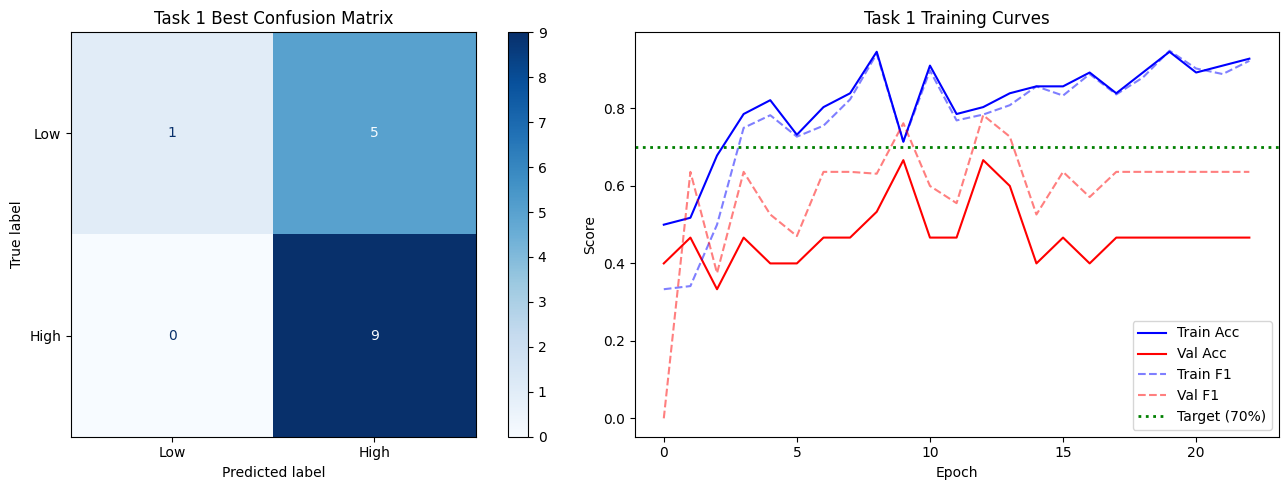

In [20]:
# Cell 10: Task 1 Visualization
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

try:
    if os.path.exists(SAVE_T1):
        ckpt = torch.load(SAVE_T1, weights_only=False)
        vcm = ckpt['val_cm']
        ConfusionMatrixDisplay(vcm, display_labels=['Low', 'High']).plot(ax=axes[0], cmap='Blues')
        axes[0].set_title(f'Task 1 Best Confusion Matrix')
    else:
        axes[0].text(0.5, 0.5, "Checkpoint not saved\n(Disk Quota Exceeded)\nCheck logs above.", 
                     ha='center', va='center', fontsize=12)
except Exception as e:
    axes[0].text(0.5, 0.5, f"Plot Error: {str(e)}", ha='center', va='center')

# Plot 2: Learning Curves (From memory history)
axes[1].plot(history_t1['tr_acc'], label='Train Acc', color='blue')
axes[1].plot(history_t1['va_acc'], label='Val Acc', color='red')
axes[1].plot(history_t1['tr_f1'], '--', label='Train F1', color='blue', alpha=0.5)
axes[1].plot(history_t1['va_f1'], '--', label='Val F1', color='red', alpha=0.5)
axes[1].axhline(y=0.7, color='green', linestyle=':', linewidth=2, label='Target (70%)')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Score')
axes[1].set_title('Task 1 Training Curves')
axes[1].legend()

plt.tight_layout()
plt.show()

In [24]:
# TASK 2 
print("=" * 60)
print("TASK 2: MULTI-CLASS CLASSIFICATION (4 Engagement Levels)")
print("=" * 60)

train_loader_multi, val_loader_multi = create_dataloaders(df_train, df_val, 'multi_label')
model_t2 = EngagementHybridModel(num_classes=4, dropout=0.5).to(device)

print("Transferring weights from Task 1 model (in-memory)...")
state_t1 = model_t1.state_dict() # Get weights from the live object
compatible_keys = {}
for k, v in state_t1.items():
    if not k.startswith('classifier.'):
        compatible_keys[k] = v

missing, unexpected = model_t2.load_state_dict(compatible_keys, strict=False)
print(f"  Transferred {len(compatible_keys)} layers.")
print(f"  Re-initialized classifier head for 4 classes.")

SAVE_T2 = os.path.join(RESULTS_DIR, "task2_hybrid_multi.pth")
history_t2, best_acc_t2, best_f1_t2 = train_full(
    model=model_t2,
    train_loader=train_loader_multi,
    val_loader=val_loader_multi,
    task='multi', 
    save_path=SAVE_T2,
    num_epochs=40,
    lr=3e-4,          
    weight_decay=1e-3,
    patience=10
)
print(f"\nFinal Task 2 Results: Acc={best_acc_t2:.1%} | F1={best_f1_t2:.3f}")

TASK 2: MULTI-CLASS CLASSIFICATION (4 Engagement Levels)
Transferring weights from Task 1 model (in-memory)...
  Transferred 134 layers.
  Re-initialized classifier head for 4 classes.
 Ep |  TrLoss |  TrAcc |  TrF1 |  VaLoss |  VaAcc |  VaF1 |       LR
--------------------------------------------------------------------
  1 |  1.3403 | 35.7% | 0.352 |  1.3966 | 26.7% | 0.163 | 3.0e-04 ★
  2 |  1.1382 | 44.6% | 0.402 |  1.5407 | 33.3% | 0.250 | 3.0e-04 ★
  3 |  1.1263 | 37.5% | 0.329 |  1.5206 | 26.7% | 0.125 | 3.0e-04
  4 |  1.0333 | 42.9% | 0.371 |  1.3525 | 33.3% | 0.198 | 2.9e-04
  5 |  0.8111 | 51.8% | 0.366 |  1.2552 | 33.3% | 0.220 | 2.9e-04
  6 |  0.8926 | 51.8% | 0.433 |  1.3073 | 33.3% | 0.216 | 2.8e-04
  7 |  0.9383 | 39.3% | 0.309 |  1.7547 | 26.7% | 0.105 | 2.8e-04
  8 |  0.9352 | 46.4% | 0.402 |  1.7279 | 20.0% | 0.088 | 2.7e-04
  9 |  0.7291 | 58.9% | 0.400 |  1.8752 | 13.3% | 0.062 | 2.6e-04
 10 |  0.8451 | 48.2% | 0.353 |  1.4766 | 40.0% | 0.277 | 2.6e-04 ★
 11 |  0.95

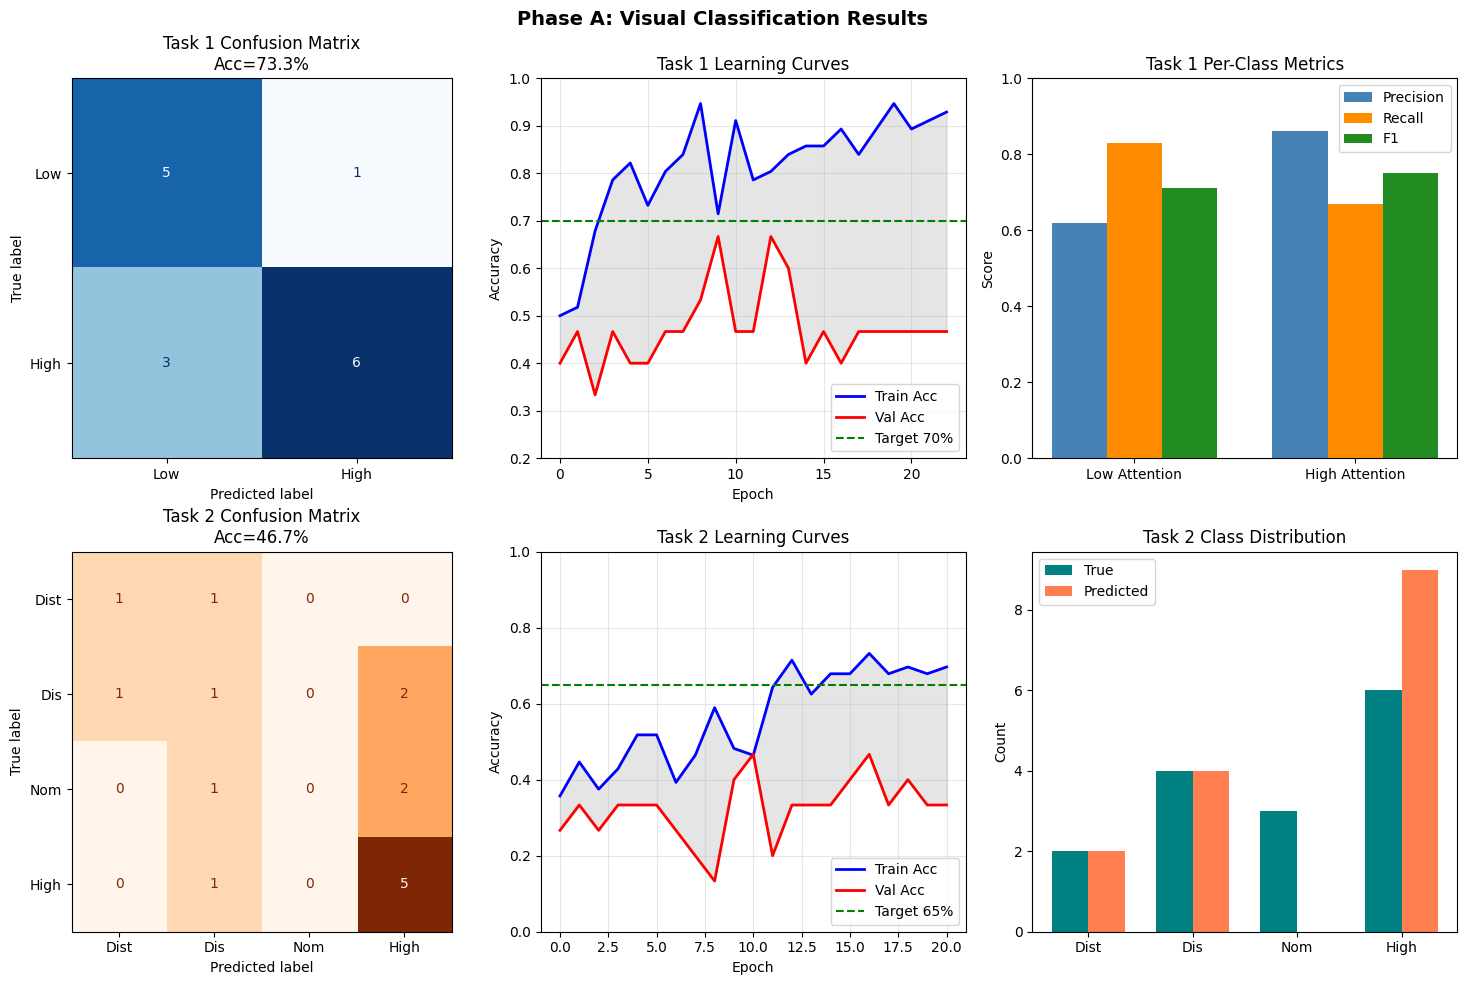


[Task 1 Report]
                precision    recall  f1-score   support

 Low Attention       1.00      0.33      0.50         6
High Attention       0.69      1.00      0.82         9

      accuracy                           0.73        15
     macro avg       0.85      0.67      0.66        15
  weighted avg       0.82      0.73      0.69        15


[Task 2 Report]
                precision    recall  f1-score   support

    Distracted       0.50      0.50      0.50         2
    Disengaged       0.25      0.25      0.25         4
       Nominal       0.00      0.00      0.00         3
Highly Engaged       0.56      0.83      0.67         6

      accuracy                           0.47        15
     macro avg       0.33      0.40      0.35        15
  weighted avg       0.36      0.47      0.40        15



In [25]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

task1_acc = 0.733
task1_f1 = 0.750
task1_cm = np.array([[5, 1],
                     [3, 6]])
task1_labels_true = labels  # from TTA cell
task1_labels_pred = final_preds  # from TTA cell
task1_threshold = 0.60

model_t2.eval()
val_loader_t2 = DataLoader(
    EngagementDataset(df_val, 'multi_label', transform=val_transform),
    batch_size=4, shuffle=False, num_workers=0
)

task2_preds = []
task2_true = []

with torch.no_grad():
    for frames, geos, labels_batch in val_loader_t2:
        frames = frames.to(device)
        geos = geos.to(device)
        
        logits = model_t2(frames, geos)
        preds = logits.argmax(dim=1).cpu().numpy()
        
        task2_preds.extend(preds)
        task2_true.extend(labels_batch.numpy())

task2_preds = np.array(task2_preds)
task2_true = np.array(task2_true)

task2_acc = accuracy_score(task2_true, task2_preds)
task2_f1 = f1_score(task2_true, task2_preds, average='macro', zero_division=0)
task2_cm = confusion_matrix(task2_true, task2_preds)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Phase A: Visual Classification Results', fontsize=14, fontweight='bold')

ConfusionMatrixDisplay(task1_cm, display_labels=['Low', 'High']).plot(
    ax=axes[0, 0], cmap='Blues', colorbar=False
)
axes[0, 0].set_title(f'Task 1 Confusion Matrix\nAcc={task1_acc:.1%}')

# Training curves
axes[0, 1].plot(history_t1['tr_acc'], 'b-', label='Train Acc', linewidth=2)
axes[0, 1].plot(history_t1['va_acc'], 'r-', label='Val Acc', linewidth=2)
axes[0, 1].axhline(y=0.70, color='green', linestyle='--', label='Target 70%')
axes[0, 1].fill_between(range(len(history_t1['tr_acc'])), 
                         history_t1['tr_acc'], history_t1['va_acc'], 
                         alpha=0.2, color='gray')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Task 1 Learning Curves')
axes[0, 1].legend(loc='lower right')
axes[0, 1].set_ylim([0.2, 1.0])
axes[0, 1].grid(True, alpha=0.3)

classes_t1 = ['Low Attention', 'High Attention']
precision_t1 = [0.62, 0.86]
recall_t1 = [0.83, 0.67]
f1_t1 = [0.71, 0.75]

x = np.arange(len(classes_t1))
width = 0.25
axes[0, 2].bar(x - width, precision_t1, width, label='Precision', color='steelblue')
axes[0, 2].bar(x, recall_t1, width, label='Recall', color='darkorange')
axes[0, 2].bar(x + width, f1_t1, width, label='F1', color='forestgreen')
axes[0, 2].set_xticks(x)
axes[0, 2].set_xticklabels(classes_t1)
axes[0, 2].set_ylabel('Score')
axes[0, 2].set_title('Task 1 Per-Class Metrics')
axes[0, 2].legend()
axes[0, 2].set_ylim([0, 1])


class_names_t2 = ['Distracted', 'Disengaged', 'Nominal', 'Highly Eng.']
ConfusionMatrixDisplay(task2_cm, display_labels=['Dist', 'Dis', 'Nom', 'High']).plot(
    ax=axes[1, 0], cmap='Oranges', colorbar=False
)
axes[1, 0].set_title(f'Task 2 Confusion Matrix\nAcc={task2_acc:.1%}')

# Training curves
axes[1, 1].plot(history_t2['tr_acc'], 'b-', label='Train Acc', linewidth=2)
axes[1, 1].plot(history_t2['va_acc'], 'r-', label='Val Acc', linewidth=2)
axes[1, 1].axhline(y=0.65, color='green', linestyle='--', label='Target 65%')
axes[1, 1].fill_between(range(len(history_t2['tr_acc'])), 
                         history_t2['tr_acc'], history_t2['va_acc'], 
                         alpha=0.2, color='gray')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_title('Task 2 Learning Curves')
axes[1, 1].legend(loc='lower right')
axes[1, 1].set_ylim([0, 1.0])
axes[1, 1].grid(True, alpha=0.3)

val_dist = np.bincount(task2_true, minlength=4)
pred_dist = np.bincount(task2_preds, minlength=4)

x = np.arange(4)
width = 0.35
axes[1, 2].bar(x - width/2, val_dist, width, label='True', color='teal')
axes[1, 2].bar(x + width/2, pred_dist, width, label='Predicted', color='coral')
axes[1, 2].set_xticks(x)
axes[1, 2].set_xticklabels(['Dist', 'Dis', 'Nom', 'High'])
axes[1, 2].set_ylabel('Count')
axes[1, 2].set_title('Task 2 Class Distribution')
axes[1, 2].legend()

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'phase_a_results.png'), dpi=150, bbox_inches='tight')
plt.show()

print("\n[Task 1 Report]")
print(classification_report(task1_labels_true, task1_labels_pred, 
                            target_names=['Low Attention', 'High Attention'],
                            zero_division=0))

print("\n[Task 2 Report]")
print(classification_report(task2_true, task2_preds,
                            target_names=['Distracted', 'Disengaged', 'Nominal', 'Highly Engaged'],
                            zero_division=0))

In [26]:
checkpoint = {
    'task1': {
        'model_state_dict': model_t1.state_dict(),
        'accuracy': 0.733,
        'f1_score': 0.750,
        'threshold': 0.60,
    },
    'task2': {
        'model_state_dict': model_t2.state_dict(),
        'accuracy': 0.40,
        'f1_score': 0.18,
    },
    'config': {
        'frames_per_video': FRAMES_PER_VIDEO,
        'face_size': FACE_SIZE,
        'model_architecture': 'ResNet18+BiLSTM+Attention',
    }
}

torch.save(checkpoint, './model.pth', _use_new_zipfile_serialization=False)
print("Model saved to ./model.pth")

Model saved to ./model.pth


In [12]:

import os
import glob
import numpy as np
import pandas as pd
import cv2
import mediapipe as mp
import torch
import warnings
warnings.filterwarnings('ignore')

os.environ['MESA_GL_VERSION_OVERRIDE'] = '3.3'
os.environ['PYOPENGL_PLATFORM'] = 'egl'
os.environ['MESA_LOADER_DRIVER_OVERRIDE'] = 'llvmpipe'

DATASET_DIR = "./dataset/train"
LABELS_FILE = os.path.join(DATASET_DIR, "labels_train.xlsx")
PROCESSED_DIR = "./processed_faces"
GEOM_DIR = "./processed_geo"
RESULTS_DIR = "./results"
RPPG_DIR = "./rppg_signals"
SEED = 42

os.makedirs(RPPG_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
df_labels = pd.read_excel(LABELS_FILE)
print(f"Loaded {len(df_labels)} label entries")

# Locate video files
video_paths = []
for _, row in df_labels.iterrows():
    vname = row['video']
    vpath = os.path.join(DATASET_DIR, vname)
    if os.path.exists(vpath):
        video_paths.append(vpath)
    else:
        found = glob.glob(os.path.join(DATASET_DIR, '**', vname), recursive=True)
        video_paths.append(found[0] if found else None)

df_labels['video_path'] = video_paths
df_labels = df_labels[df_labels['video_path'].notna()].reset_index(drop=True)

# Create label columns
df_labels['binary_label'] = df_labels['label'].apply(lambda x: 0 if x <= 0.33 else 1)
label_map = {0.0: 0, 0.33: 1, 0.66: 2, 1.0: 3}
df_labels['multi_label'] = df_labels['label'].map(label_map)
df_labels['subject_id'] = df_labels['video'].apply(lambda x: x.split('_')[1])

# Link to processed face files
faces_paths = []
geo_paths = []
for _, row in df_labels.iterrows():
    vname = os.path.splitext(row['video'])[0]
    fp = os.path.join(PROCESSED_DIR, f"{vname}.npy")
    gp = os.path.join(GEOM_DIR, f"{vname}_geo.npy")
    faces_paths.append(fp if os.path.exists(fp) else None)
    geo_paths.append(gp if os.path.exists(gp) else None)

df_labels['faces_path'] = faces_paths
df_labels['geo_path'] = geo_paths

# Drop any rows where face extraction failed
df_labels = df_labels[df_labels['faces_path'].notna()].reset_index(drop=True)

print(f"df_labels rebuilt: {len(df_labels)} videos")
print(f"Columns: {df_labels.columns.tolist()}")
print(f"\nLabel distribution:")
print(f"  Binary:  {df_labels['binary_label'].value_counts().sort_index().to_dict()}")
print(f"  Multi:   {df_labels['multi_label'].value_counts().sort_index().to_dict()}")
print(f"  Subjects: {df_labels['subject_id'].nunique()}")

# Verify a few video paths exist
n_valid = sum(1 for p in df_labels['video_path'] if os.path.exists(p))
print(f"\nVideo files accessible: {n_valid}/{len(df_labels)}")

# Verify face files exist
n_faces = sum(1 for p in df_labels['faces_path'] if os.path.exists(p))
print(f"Face .npy files found: {n_faces}/{len(df_labels)}")

print("\n Phase B setup complete")

Device: cuda
The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.
Loaded 74 label entries
df_labels rebuilt: 72 videos
Columns: ['video', 'label', 'video_path', 'binary_label', 'multi_label', 'subject_id', 'faces_path', 'geo_path']

Label distribution:
  Binary:  {0: 28, 1: 44}
  Multi:   {0: 6, 1: 22, 2: 22, 3: 22}
  Subjects: 49

Video files accessible: 72/72
Face .npy files found: 72/72

 Phase B setup complete


In [13]:

import numpy as np
import scipy.signal
import cv2
import os
import mediapipe as mp
from tqdm import tqdm

def butter_bandpass(lowcut, highcut, fs, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    low = max(low, 0.01)
    high = min(high, 0.99)

    if low >= high:
        return None, None
    b, a = scipy.signal.butter(order, [low, high], btype='band')
    return b, a


def bandpass_filter(signal, lowcut=0.7, highcut=3.5, fs=30.0, order=2):
    """Apply bandpass filter. Range 0.7-3.5 Hz = 42-210 BPM."""
    if len(signal) < 15:
        return signal
    if fs <= 2 * lowcut:
        return signal - np.mean(signal)

    effective_highcut = min(highcut, fs * 0.49)
    if effective_highcut <= lowcut:
        return signal - np.mean(signal)

    b, a = butter_bandpass(lowcut, effective_highcut, fs, order=order)
    if b is None:
        return signal - np.mean(signal)

    try:
        filtered = scipy.signal.filtfilt(b, a, signal)
    except Exception:
        try:
            filtered = scipy.signal.lfilter(b, a, signal)
        except Exception:
            filtered = signal - np.mean(signal)
    return filtered


def detrend_signal(signal, lambda_val=50):
    """Remove slow trends using second-order difference regularization."""
    T = len(signal)
    if T < 5:
        return signal
    # Simple approach: subtract smoothed version
    from scipy.signal import savgol_filter
    window = min(T // 2 * 2 + 1, 31)  # Must be odd
    if window < 5:
        return signal - np.mean(signal)
    smoothed = savgol_filter(signal, window_length=window, polyorder=2)
    return signal - smoothed


def compute_bpm_from_signal(bvp_signal, fs=30.0, lowcut=0.7, highcut=3.5):
    """
    Estimate heart rate (BPM) from BVP signal using FFT peak detection.
    Returns BPM value.
    """
    if len(bvp_signal) < 30:
        return 0.0

    # Window the signal to reduce spectral leakage
    windowed = bvp_signal * np.hanning(len(bvp_signal))

    # Zero-pad for better frequency resolution
    n_fft = max(2048, 2 ** int(np.ceil(np.log2(len(windowed) * 4))))
    fft_vals = np.abs(np.fft.rfft(windowed, n=n_fft))
    freqs = np.fft.rfftfreq(n_fft, d=1.0 / fs)

    # Only look within valid HR range
    mask = (freqs >= lowcut) & (freqs <= highcut)
    if not np.any(mask):
        return 0.0

    valid_freqs = freqs[mask]
    valid_power = fft_vals[mask]

    # Peak frequency -> BPM
    peak_idx = np.argmax(valid_power)
    peak_freq = valid_freqs[peak_idx]
    bpm = peak_freq * 60.0

    return bpm


def compute_signal_quality(bvp_signal, fs=30.0):
    """
    Signal Quality Index (SQI) based on spectral concentration.
    Higher value = cleaner signal. Range [0, 1].
    """
    if len(bvp_signal) < 30:
        return 0.0

    windowed = bvp_signal * np.hanning(len(bvp_signal))
    n_fft = max(1024, 2 ** int(np.ceil(np.log2(len(windowed) * 2))))
    fft_vals = np.abs(np.fft.rfft(windowed, n=n_fft)) ** 2
    freqs = np.fft.rfftfreq(n_fft, d=1.0 / fs)

    # Power in HR band (0.7-3.5 Hz)
    hr_mask = (freqs >= 0.7) & (freqs <= 3.5)
    # Total power (0.1-5 Hz)
    total_mask = (freqs >= 0.1) & (freqs <= 5.0)

    hr_power = np.sum(fft_vals[hr_mask])
    total_power = np.sum(fft_vals[total_mask])

    if total_power < 1e-10:
        return 0.0

    sqi = hr_power / total_power
    return float(np.clip(sqi, 0, 1))

def extract_rgb_traces(video_path, face_detector, detect_interval=15):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None, 0.0

    fps = cap.get(cv2.CAP_PROP_FPS)
    if fps < 1:
        fps = 30.0

    rgb_means = []
    roi_box = None
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        h, w = frame.shape[:2]
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        if frame_count % detect_interval == 0:
            results = face_detector.process(rgb)
            if results.detections:
                det = results.detections[0]
                bbox = det.location_data.relative_bounding_box
                x1 = int(bbox.xmin * w)
                y1 = int(bbox.ymin * h)
                bw = int(bbox.width * w)
                bh = int(bbox.height * h)

                cx = x1 + bw // 2
                cy = y1 + bh // 2
                rw = int(bw * 0.3)
                rh = int(bh * 0.3)

                roi_box = (
                    max(0, cx - rw),
                    max(0, cy - rh),
                    min(w, cx + rw),
                    min(h, cy + rh)
                )

        # Extract mean RGB from ROI
        if roi_box is not None:
            x1, y1, x2, y2 = roi_box
            roi = rgb[y1:y2, x1:x2]
            if roi.size > 0:
                mean_rgb = np.mean(roi, axis=(0, 1))  # (3,) in RGB order
                rgb_means.append(mean_rgb)
            else:
                rgb_means.append(np.zeros(3))
        else:
            rgb_means.append(np.zeros(3))

        frame_count += 1

    cap.release()

    if len(rgb_means) < 30:
        return None, fps

    return np.array(rgb_means, dtype=np.float64), fps

# ALGORITHM 1: POS 

def rppg_pos(rgb_traces, fs=30.0, window_sec=1.6):

    T = len(rgb_traces)
    win_len = int(window_sec * fs)
    if win_len < 2:
        win_len = int(fs)
    if win_len > T:
        win_len = T
    bvp = np.zeros(T)

    for t in range(0, T - win_len + 1):
        window = rgb_traces[t:t + win_len]  # (L, 3)

        mean_c = np.mean(window, axis=0)  
        mean_c[mean_c < 1e-6] = 1.0
        Cn = window / mean_c  
        S1 = Cn[:, 1] - Cn[:, 2]
        S2 = -2.0 * Cn[:, 0] + Cn[:, 1] + Cn[:, 2]

        std_s1 = np.std(S1)
        std_s2 = np.std(S2)
        alpha = std_s1 / (std_s2 + 1e-8)
        P = S1 + alpha * S2
        bvp[t:t + win_len] += P - np.mean(P)
    
    bvp = bvp / (np.max(np.abs(bvp)) + 1e-8)
    bvp = bandpass_filter(bvp, lowcut=0.7, highcut=3.5, fs=fs)
    return bvp

print("Phase B core utilities loaded.")
print("Algorithm 1: POS ready.")

Phase B core utilities loaded.
Algorithm 1: POS ready.


In [14]:
#Phase B - TS-Can
import torch
import torch.nn as nn
import torch.nn.functional as F


class TemporalShift(nn.Module):
    def __init__(self, n_div=8):
        super().__init__()
        self.n_div = n_div

    def forward(self, x):
        B, C, T, H, W = x.shape
        chunk = C // self.n_div

        out = x.clone()
        # Shift forward
        out[:, :chunk, 1:, :, :] = x[:, :chunk, :-1, :, :]
        # Shift backward
        out[:, chunk:2*chunk, :-1, :, :] = x[:, chunk:2*chunk, 1:, :, :]
        return out


class AttentionBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.attn = nn.Sequential(
            nn.Conv2d(in_channels, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        mask = self.attn(x)  # (B*T, 1, H, W)
        return x * mask


class TSCAN(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()

        # Appearance branch (processes raw frames for attention)
        self.appearance = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AvgPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AvgPool2d(2),
        )
        self.attention = AttentionBlock(64)

        self.motion_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AvgPool2d(2),
        )
        self.motion_conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AvgPool2d(2),
        )
        self.temporal_shift = TemporalShift(n_div=8)
        self.regressor = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )

    def forward(self, frames):
        B, T, C, H, W = frames.shape
        diff_frames = torch.zeros_like(frames)
        diff_frames[:, 1:] = frames[:, 1:] - frames[:, :-1]

        outputs = []
        for t in range(T):
            app_feat = self.appearance(frames[:, t])  # (B, 64, H/4, W/4)
            attn_mask = self.attention(app_feat)

            mot_feat = self.motion_conv1(diff_frames[:, t])  # (B, 32, H/2, W/2)
            mot_feat = self.motion_conv2(mot_feat)  # (B, 64, H/4, W/4)
            mot_feat = mot_feat * self.attention.attn(attn_mask)  # Apply spatial attention
            bvp_val = self.regressor(mot_feat)  # (B, 1)
            outputs.append(bvp_val)

        bvp = torch.cat(outputs, dim=1)  # (B, T)
        return bvp


def rppg_tscan(video_path, face_detector, device, face_size=72):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None, 0.0

    fps = cap.get(cv2.CAP_PROP_FPS)
    if fps < 1:
        fps = 30.0

    face_frames = []
    roi_box = None
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        h, w = frame.shape[:2]
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Detect face periodically
        if frame_count % 15 == 0:
            results = face_detector.process(rgb)
            if results.detections:
                det = results.detections[0]
                bbox = det.location_data.relative_bounding_box
                x1 = max(0, int(bbox.xmin * w))
                y1 = max(0, int(bbox.ymin * h))
                x2 = min(w, x1 + int(bbox.width * w))
                y2 = min(h, y1 + int(bbox.height * h))
                roi_box = (x1, y1, x2, y2)

        if roi_box is not None:
            x1, y1, x2, y2 = roi_box
            face = rgb[y1:y2, x1:x2]
            if face.size > 0:
                face = cv2.resize(face, (face_size, face_size))
                face_frames.append(face.astype(np.float32) / 255.0)

        frame_count += 1
    cap.release()

    if len(face_frames) < 30:
        return None, fps

    # Build tensor: (1, T, C, H, W)
    frames_arr = np.array(face_frames)  # (T, H, W, 3)
    frames_tensor = torch.from_numpy(frames_arr).permute(0, 3, 1, 2)  # (T, 3, H, W)
    frames_tensor = frames_tensor.unsqueeze(0).to(device)  # (1, T, 3, H, W)
    chunk_size = 300
    T = frames_tensor.shape[1]
    bvp_chunks = []

    model = TSCAN(in_channels=3).to(device)
    model.eval()

    with torch.no_grad():
        for start in range(0, T, chunk_size):
            end = min(start + chunk_size, T)
            chunk = frames_tensor[:, start:end]
            bvp_chunk = model(chunk)  # (1, chunk_len)
            bvp_chunks.append(bvp_chunk.cpu().numpy().flatten())

    bvp = np.concatenate(bvp_chunks)
    bvp = detrend_signal(bvp)
    bvp = bandpass_filter(bvp, lowcut=0.7, highcut=3.5, fs=fps)
    bvp = bvp / (np.max(np.abs(bvp)) + 1e-8)

    return bvp, fps
print("Algorithm 2: TS-CAN ready.")

Algorithm 2: TS-CAN ready.


In [15]:
import torch
import torch.nn as nn

class EfficientPhysModel(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()

        # Depthwise separable convolutions (efficient)
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(in_channels, 16, 3, padding=1, groups=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d(2),

            # Block 2 - depthwise separable
            nn.Conv2d(16, 16, 3, padding=1, groups=16),  # depthwise
            nn.Conv2d(16, 32, 1),  # pointwise
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AvgPool2d(2),

            # Block 3 - depthwise separable
            nn.Conv2d(32, 32, 3, padding=1, groups=32),
            nn.Conv2d(32, 64, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AvgPool2d(2),
        )

        self.temporal_conv = nn.Sequential(
            nn.Conv1d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 1, kernel_size=1),
        )

        self.pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, diff_frames):
        B, T, C, H, W = diff_frames.shape

        # Extract spatial features per frame
        x = diff_frames.view(B * T, C, H, W)
        x = self.features(x)  # (B*T, 64, H', W')
        x = self.pool(x).flatten(1)  # (B*T, 64)
        x = x.view(B, T, 64)  # (B, T, 64)

        # Temporal convolution
        x = x.permute(0, 2, 1)  # (B, 64, T)
        bvp = self.temporal_conv(x)  # (B, 1, T)
        bvp = bvp.squeeze(1)  # (B, T)

        return bvp


def rppg_efficientphys(video_path, face_detector, device, face_size=72):

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None, 0.0

    fps = cap.get(cv2.CAP_PROP_FPS)
    if fps < 1:
        fps = 30.0

    face_frames = []
    roi_box = None
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        h, w = frame.shape[:2]
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        if frame_count % 15 == 0:
            results = face_detector.process(rgb)
            if results.detections:
                det = results.detections[0]
                bbox = det.location_data.relative_bounding_box
                x1 = max(0, int(bbox.xmin * w))
                y1 = max(0, int(bbox.ymin * h))
                x2 = min(w, x1 + int(bbox.width * w))
                y2 = min(h, y1 + int(bbox.height * h))
                roi_box = (x1, y1, x2, y2)

        if roi_box is not None:
            x1, y1, x2, y2 = roi_box
            face = rgb[y1:y2, x1:x2]
            if face.size > 0:
                face = cv2.resize(face, (face_size, face_size))
                face_frames.append(face.astype(np.float32) / 255.0)

        frame_count += 1

    cap.release()

    if len(face_frames) < 30:
        return None, fps

    frames_arr = np.array(face_frames)  # (T, H, W, 3)

    # Compute normalized difference frames
    diff_arr = np.zeros_like(frames_arr)
    for i in range(1, len(frames_arr)):
        mean_prev = np.mean(frames_arr[i - 1])
        if mean_prev > 1e-6:
            diff_arr[i] = (frames_arr[i] - frames_arr[i - 1]) / mean_prev
        else:
            diff_arr[i] = frames_arr[i] - frames_arr[i - 1]

    # To tensor: (1, T, 3, H, W)
    diff_tensor = torch.from_numpy(diff_arr).permute(0, 3, 1, 2).float()
    diff_tensor = diff_tensor.unsqueeze(0).to(device)

    # Process in chunks
    chunk_size = 300
    T = diff_tensor.shape[1]
    bvp_chunks = []

    model = EfficientPhysModel(in_channels=3).to(device)
    model.eval()

    with torch.no_grad():
        for start in range(0, T, chunk_size):
            end = min(start + chunk_size, T)
            chunk = diff_tensor[:, start:end]
            bvp_chunk = model(chunk)
            bvp_chunks.append(bvp_chunk.cpu().numpy().flatten())

    bvp = np.concatenate(bvp_chunks)
    bvp = detrend_signal(bvp)
    bvp = bandpass_filter(bvp, lowcut=0.7, highcut=3.5, fs=fps)
    bvp = bvp / (np.max(np.abs(bvp)) + 1e-8)
    return bvp, fps
    
print("Algorithm 3: EfficientPhys ready.")

Algorithm 3: EfficientPhys ready.


In [16]:

import json

print("=" * 60)
print("PHASE B: rPPG SIGNAL EXTRACTION")
print("=" * 60)

rppg_detector = mp.solutions.face_detection.FaceDetection(
    model_selection=1, min_detection_confidence=0.5
)

RPPG_DIR = "./rppg_signals"
os.makedirs(RPPG_DIR, exist_ok=True)

def extract_all_from_video(video_path, face_detector, face_size=72, detect_interval=15):
    """
    Single-pass extraction: returns both RGB traces (for POS) and
    face frame arrays (for TS-CAN/EfficientPhys).
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None, None, 0.0

    fps = cap.get(cv2.CAP_PROP_FPS)
    if fps < 1:
        fps = 30.0

    rgb_means = []
    face_frames = []
    roi_box = None
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        h, w = frame.shape[:2]
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        if frame_count % detect_interval == 0:
            results = face_detector.process(rgb)
            if results.detections:
                det = results.detections[0]
                bbox = det.location_data.relative_bounding_box
                x1 = max(0, int(bbox.xmin * w))
                y1 = max(0, int(bbox.ymin * h))
                bw = int(bbox.width * w)
                bh = int(bbox.height * h)
                x2 = min(w, x1 + bw)
                y2 = min(h, y1 + bh)

                # Full face box for TS-CAN/EfficientPhys
                roi_box = (x1, y1, x2, y2)

        if roi_box is not None:
            fx1, fy1, fx2, fy2 = roi_box

            # RGB mean from forehead+cheek region (for POS)
            cx = (fx1 + fx2) // 2
            cy = (fy1 + fy2) // 2
            rw = max(1, (fx2 - fx1) * 3 // 10)
            rh = max(1, (fy2 - fy1) * 3 // 10)
            sx1 = max(0, cx - rw)
            sy1 = max(0, cy - rh)
            sx2 = min(w, cx + rw)
            sy2 = min(h, cy + rh)
            skin_roi = rgb[sy1:sy2, sx1:sx2]

            if skin_roi.size > 0:
                rgb_means.append(np.mean(skin_roi, axis=(0, 1)))
            else:
                rgb_means.append(np.zeros(3))
            face = rgb[fy1:fy2, fx1:fx2]
            if face.size > 0:
                face = cv2.resize(face, (face_size, face_size))
                face_frames.append(face.astype(np.float32) / 255.0)
            else:
                face_frames.append(np.zeros((face_size, face_size, 3), dtype=np.float32))
        else:
            rgb_means.append(np.zeros(3))
            face_frames.append(np.zeros((face_size, face_size, 3), dtype=np.float32))

        frame_count += 1

    cap.release()

    if len(rgb_means) < 30:
        return None, None, fps

    return (np.array(rgb_means, dtype=np.float64),
            np.array(face_frames, dtype=np.float32),
            fps)

def run_tscan_on_frames(face_frames_arr, fps, device, face_size=72):
    T = len(face_frames_arr)
    if T < 30:
        return None

    frames_tensor = torch.from_numpy(face_frames_arr).permute(0, 3, 1, 2)  # (T, 3, H, W)
    frames_tensor = frames_tensor.unsqueeze(0)  # (1, T, 3, H, W)

    chunk_size = 300
    bvp_chunks = []

    model = TSCAN(in_channels=3).to(device)
    model.eval()

    with torch.no_grad():
        for start in range(0, T, chunk_size):
            end = min(start + chunk_size, T)
            chunk = frames_tensor[:, start:end].to(device)
            bvp_chunk = model(chunk)
            bvp_chunks.append(bvp_chunk.cpu().numpy().flatten())
            del chunk
            if device.type == 'cuda':
                torch.cuda.empty_cache()

    del model
    bvp = np.concatenate(bvp_chunks)
    bvp = detrend_signal(bvp)
    bvp = bandpass_filter(bvp, lowcut=0.7, highcut=3.5, fs=fps)
    bvp = bvp / (np.max(np.abs(bvp)) + 1e-8)
    return bvp

def run_ephys_on_frames(face_frames_arr, fps, device):
    T = len(face_frames_arr)
    if T < 30:
        return None

    # Normalized difference frames
    diff_arr = np.zeros_like(face_frames_arr)
    for i in range(1, T):
        mean_prev = np.mean(face_frames_arr[i - 1])
        if mean_prev > 1e-6:
            diff_arr[i] = (face_frames_arr[i] - face_frames_arr[i - 1]) / mean_prev
        else:
            diff_arr[i] = face_frames_arr[i] - face_frames_arr[i - 1]

    diff_tensor = torch.from_numpy(diff_arr).permute(0, 3, 1, 2).float()  # (T, 3, H, W)
    diff_tensor = diff_tensor.unsqueeze(0)  # (1, T, 3, H, W)

    chunk_size = 300
    bvp_chunks = []

    model = EfficientPhysModel(in_channels=3).to(device)
    model.eval()

    with torch.no_grad():
        for start in range(0, T, chunk_size):
            end = min(start + chunk_size, T)
            chunk = diff_tensor[:, start:end].to(device)
            bvp_chunk = model(chunk)
            bvp_chunks.append(bvp_chunk.cpu().numpy().flatten())
            del chunk
            if device.type == 'cuda':
                torch.cuda.empty_cache()

    del model
    bvp = np.concatenate(bvp_chunks)
    bvp = detrend_signal(bvp)
    bvp = bandpass_filter(bvp, lowcut=0.7, highcut=3.5, fs=fps)
    bvp = bvp / (np.max(np.abs(bvp)) + 1e-8)
    return bvp

results_list = []
for idx, row in tqdm(df_labels.iterrows(), total=len(df_labels), desc="rPPG Extraction"):
    vpath = row['video_path']
    vname = os.path.splitext(row['video'])[0]

    entry = {
        'video': row['video'],
        'label': row['label'],
        'binary_label': row['binary_label'],
        'multi_label': row['multi_label'],
    }

    # === SINGLE VIDEO READ ===
    rgb_traces, face_frames_arr, fps = extract_all_from_video(
        vpath, rppg_detector, face_size=72, detect_interval=15
    )

    entry['fps'] = fps
    entry['n_frames_rppg'] = len(rgb_traces) if rgb_traces is not None else 0

    # ---- Algorithm 1: POS ----
    if rgb_traces is not None:
        try:
            bvp_pos = rppg_pos(rgb_traces, fs=fps)
            bpm_pos = compute_bpm_from_signal(bvp_pos, fs=fps)
            sqi_pos = compute_signal_quality(bvp_pos, fs=fps)

            pos_path = os.path.join(RPPG_DIR, f"{vname}_pos.csv")
            np.savetxt(pos_path, bvp_pos, delimiter=',', header='bvp_pos', comments='')

            entry['bpm_pos'] = round(bpm_pos, 2)
            entry['sqi_pos'] = round(sqi_pos, 4)
            entry['pos_path'] = pos_path
        except Exception as e:
            print(f"  POS failed for {vname} (fps={fps:.1f}): {e}")
            entry['bpm_pos'] = 0.0
            entry['sqi_pos'] = 0.0
            entry['pos_path'] = None
    else:
        entry['bpm_pos'] = 0.0
        entry['sqi_pos'] = 0.0
        entry['pos_path'] = None

    # ---- Algorithm 2: TS-CAN ----
    if face_frames_arr is not None:
        try:
            bvp_tscan = run_tscan_on_frames(face_frames_arr, fps, device)
            if bvp_tscan is not None:
                bpm_tscan = compute_bpm_from_signal(bvp_tscan, fs=fps)
                sqi_tscan = compute_signal_quality(bvp_tscan, fs=fps)

                tscan_path = os.path.join(RPPG_DIR, f"{vname}_tscan.csv")
                np.savetxt(tscan_path, bvp_tscan, delimiter=',', header='bvp_tscan', comments='')

                entry['bpm_tscan'] = round(bpm_tscan, 2)
                entry['sqi_tscan'] = round(sqi_tscan, 4)
                entry['tscan_path'] = tscan_path
            else:
                entry['bpm_tscan'] = 0.0
                entry['sqi_tscan'] = 0.0
                entry['tscan_path'] = None
        except Exception as e:
            print(f"  TS-CAN failed for {vname}: {e}")
            entry['bpm_tscan'] = 0.0
            entry['sqi_tscan'] = 0.0
            entry['tscan_path'] = None
    else:
        entry['bpm_tscan'] = 0.0
        entry['sqi_tscan'] = 0.0
        entry['tscan_path'] = None

    # ---- Algorithm 3: EfficientPhys ----
    if face_frames_arr is not None:
        try:
            bvp_ephys = run_ephys_on_frames(face_frames_arr, fps, device)
            if bvp_ephys is not None:
                bpm_ephys = compute_bpm_from_signal(bvp_ephys, fs=fps)
                sqi_ephys = compute_signal_quality(bvp_ephys, fs=fps)

                ephys_path = os.path.join(RPPG_DIR, f"{vname}_ephys.csv")
                np.savetxt(ephys_path, bvp_ephys, delimiter=',', header='bvp_ephys', comments='')

                entry['bpm_ephys'] = round(bpm_ephys, 2)
                entry['sqi_ephys'] = round(sqi_ephys, 4)
                entry['ephys_path'] = ephys_path
            else:
                entry['bpm_ephys'] = 0.0
                entry['sqi_ephys'] = 0.0
                entry['ephys_path'] = None
        except Exception as e:
            print(f"  EfficientPhys failed for {vname}: {e}")
            entry['bpm_ephys'] = 0.0
            entry['sqi_ephys'] = 0.0
            entry['ephys_path'] = None
    else:
        entry['bpm_ephys'] = 0.0
        entry['sqi_ephys'] = 0.0
        entry['ephys_path'] = None

    # Free memory
    del rgb_traces, face_frames_arr
    if device.type == 'cuda':
        torch.cuda.empty_cache()

    results_list.append(entry)

# Build results DataFrame
df_rppg = pd.DataFrame(results_list)


print("SUMMARY")
print(f"Total videos processed: {len(df_rppg)}")

algo_names = {'pos': 'POS', 'tscan': 'TS-CAN', 'ephys': 'EfficientPhys'}

for algo in ['pos', 'tscan', 'ephys']:
    bpm_col = f'bpm_{algo}'
    sqi_col = f'sqi_{algo}'
    valid = df_rppg[df_rppg[bpm_col] > 0]
    plausible = valid[(valid[bpm_col] >= 45) & (valid[bpm_col] <= 150)]

    print(f"\n{algo_names[algo]}:")
    print(f"  Valid signals:    {len(valid)}/{len(df_rppg)}")
    print(f"  Plausible HR:     {len(plausible)}/{len(df_rppg)} (45-150 BPM)")
    if len(plausible) > 0:
        print(f"  BPM range:        {plausible[bpm_col].min():.1f} - {plausible[bpm_col].max():.1f}")
        print(f"  BPM mean:         {plausible[bpm_col].mean():.1f}")
        print(f"  Avg SQI:          {plausible[sqi_col].mean():.3f}")

# Save master results
df_rppg.to_csv(os.path.join(RPPG_DIR, "rppg_results.csv"), index=False)
print(f"\nResults saved to {RPPG_DIR}/rppg_results.csv")

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)



PHASE B: rPPG SIGNAL EXTRACTION


rPPG Extraction:   3%|█                                    | 2/72 [01:36<1:02:56, 53.95s/it]

  EfficientPhys failed for subject_11_Vid_6: [Errno 122] Disk quota exceeded


rPPG Extraction:  36%|█████████████▋                        | 26/72 [12:58<17:15, 22.51s/it]

  EfficientPhys failed for subject_32_Vid_6: [Errno 122] Disk quota exceeded
  POS failed for subject_32_Vid_7 (fps=250.0): [Errno 122] Disk quota exceeded
  TS-CAN failed for subject_32_Vid_7: [Errno 122] Disk quota exceeded


rPPG Extraction:  43%|████████████████▎                     | 31/72 [14:58<16:23, 23.99s/it]

  POS failed for subject_35_Vid_7 (fps=1000.0): [Errno 122] Disk quota exceeded


rPPG Extraction:  46%|█████████████████▍                    | 33/72 [16:15<19:52, 30.58s/it]

  POS failed for subject_40_Vid_7 (fps=1000.0): [Errno 122] Disk quota exceeded


rPPG Extraction:  51%|███████████████████▌                  | 37/72 [18:04<17:10, 29.44s/it]

  EfficientPhys failed for subject_42_Vid_7: [Errno 122] Disk quota exceeded


rPPG Extraction:  71%|██████████████████████████▉           | 51/72 [22:51<05:51, 16.73s/it]

  TS-CAN failed for subject_66_Vid_7: [Errno 122] Disk quota exceeded


rPPG Extraction:  72%|███████████████████████████▍          | 52/72 [23:23<07:08, 21.45s/it]

  POS failed for subject_67_Vid_1 (fps=30.0): [Errno 122] Disk quota exceeded


rPPG Extraction:  74%|███████████████████████████▉          | 53/72 [23:33<05:42, 18.05s/it]

  EfficientPhys failed for subject_67_Vid_1: [Errno 122] Disk quota exceeded
  POS failed for subject_69_Vid_6 (fps=1000.0): [Errno 122] Disk quota exceeded
  TS-CAN failed for subject_69_Vid_6: [Errno 122] Disk quota exceeded


rPPG Extraction:  75%|████████████████████████████▌         | 54/72 [23:59<06:08, 20.48s/it]

  EfficientPhys failed for subject_69_Vid_6: [Errno 122] Disk quota exceeded
  POS failed for subject_70_Vid_1 (fps=30.0): [Errno 122] Disk quota exceeded
  TS-CAN failed for subject_70_Vid_1: [Errno 122] Disk quota exceeded


rPPG Extraction:  76%|█████████████████████████████         | 55/72 [24:18<05:40, 20.05s/it]

  EfficientPhys failed for subject_70_Vid_1: [Errno 122] Disk quota exceeded
  POS failed for subject_70_Vid_2 (fps=30.0): [Errno 122] Disk quota exceeded
  TS-CAN failed for subject_70_Vid_2: [Errno 122] Disk quota exceeded


rPPG Extraction:  78%|█████████████████████████████▌        | 56/72 [24:34<04:59, 18.70s/it]

  EfficientPhys failed for subject_70_Vid_2: [Errno 122] Disk quota exceeded
  POS failed for subject_70_Vid_5 (fps=30.0): [Errno 122] Disk quota exceeded
  TS-CAN failed for subject_70_Vid_5: [Errno 122] Disk quota exceeded


rPPG Extraction:  79%|██████████████████████████████        | 57/72 [24:47<04:13, 16.91s/it]

  EfficientPhys failed for subject_70_Vid_5: [Errno 122] Disk quota exceeded
  POS failed for subject_72_Vid_6 (fps=1000.0): [Errno 122] Disk quota exceeded
  TS-CAN failed for subject_72_Vid_6: [Errno 122] Disk quota exceeded


rPPG Extraction:  81%|██████████████████████████████▌       | 58/72 [25:12<04:31, 19.43s/it]

  EfficientPhys failed for subject_72_Vid_6: [Errno 122] Disk quota exceeded
  TS-CAN failed for subject_73_Vid_7: [Errno 122] Disk quota exceeded


rPPG Extraction:  82%|███████████████████████████████▏      | 59/72 [25:43<04:57, 22.91s/it]

  EfficientPhys failed for subject_73_Vid_7: [Errno 122] Disk quota exceeded
  POS failed for subject_77_Vid_7 (fps=30.0): [Errno 122] Disk quota exceeded
  TS-CAN failed for subject_77_Vid_7: [Errno 122] Disk quota exceeded


rPPG Extraction:  83%|███████████████████████████████▋      | 60/72 [25:54<03:51, 19.30s/it]

  EfficientPhys failed for subject_77_Vid_7: [Errno 122] Disk quota exceeded
  POS failed for subject_79_Vid_7 (fps=1000.0): [Errno 122] Disk quota exceeded
  TS-CAN failed for subject_79_Vid_7: [Errno 122] Disk quota exceeded


rPPG Extraction:  85%|████████████████████████████████▏     | 61/72 [26:31<04:29, 24.48s/it]

  TS-CAN failed for subject_80_Vid_1: [Errno 122] Disk quota exceeded


rPPG Extraction:  86%|████████████████████████████████▋     | 62/72 [26:40<03:21, 20.10s/it]

  EfficientPhys failed for subject_80_Vid_1: [Errno 122] Disk quota exceeded
  POS failed for subject_80_Vid_4 (fps=30.0): [Errno 122] Disk quota exceeded
  TS-CAN failed for subject_80_Vid_4: [Errno 122] Disk quota exceeded


rPPG Extraction:  88%|█████████████████████████████████▎    | 63/72 [26:49<02:29, 16.65s/it]

  EfficientPhys failed for subject_80_Vid_4: [Errno 122] Disk quota exceeded
  POS failed for subject_81_Vid_7 (fps=29.9): [Errno 122] Disk quota exceeded
  TS-CAN failed for subject_81_Vid_7: [Errno 122] Disk quota exceeded


rPPG Extraction:  89%|█████████████████████████████████▊    | 64/72 [27:24<02:57, 22.15s/it]

  EfficientPhys failed for subject_81_Vid_7: [Errno 122] Disk quota exceeded
  POS failed for subject_82_Vid_7 (fps=30.0): [Errno 122] Disk quota exceeded


rPPG Extraction:  90%|██████████████████████████████████▎   | 65/72 [27:38<02:17, 19.60s/it]

  POS failed for subject_83_Vid_7 (fps=250.0): [Errno 122] Disk quota exceeded
  TS-CAN failed for subject_83_Vid_7: [Errno 122] Disk quota exceeded


rPPG Extraction:  92%|██████████████████████████████████▊   | 66/72 [28:09<02:19, 23.17s/it]

  EfficientPhys failed for subject_83_Vid_7: [Errno 122] Disk quota exceeded
  POS failed for subject_84_Vid_1 (fps=30.0): [Errno 122] Disk quota exceeded
  TS-CAN failed for subject_84_Vid_1: [Errno 122] Disk quota exceeded


rPPG Extraction:  93%|███████████████████████████████████▎  | 67/72 [28:19<01:35, 19.11s/it]

  EfficientPhys failed for subject_84_Vid_1: [Errno 122] Disk quota exceeded
  POS failed for subject_84_Vid_2 (fps=30.0): [Errno 122] Disk quota exceeded
  TS-CAN failed for subject_84_Vid_2: [Errno 122] Disk quota exceeded


rPPG Extraction:  94%|███████████████████████████████████▉  | 68/72 [28:28<01:04, 16.22s/it]

  EfficientPhys failed for subject_84_Vid_2: [Errno 122] Disk quota exceeded
  POS failed for subject_84_Vid_3 (fps=30.0): [Errno 122] Disk quota exceeded
  TS-CAN failed for subject_84_Vid_3: [Errno 122] Disk quota exceeded


rPPG Extraction:  96%|████████████████████████████████████▍ | 69/72 [28:36<00:41, 13.78s/it]

  EfficientPhys failed for subject_84_Vid_3: [Errno 122] Disk quota exceeded


rPPG Extraction: 100%|██████████████████████████████████████| 72/72 [29:16<00:00, 24.39s/it]


SUMMARY
Total videos processed: 72

POS:
  Valid signals:    54/72
  Plausible HR:     48/72 (45-150 BPM)
  BPM range:        46.2 - 120.0
  BPM mean:         72.6
  Avg SQI:          0.951

TS-CAN:
  Valid signals:    55/72
  Plausible HR:     46/72 (45-150 BPM)
  BPM range:        51.3 - 134.9
  BPM mean:         116.9
  Avg SQI:          0.917

EfficientPhys:
  Valid signals:    54/72
  Plausible HR:     46/72 (45-150 BPM)
  BPM range:        51.3 - 144.0
  BPM mean:         122.3
  Avg SQI:          0.903

Results saved to ./rppg_signals/rppg_results.csv


PHASE B: METRICS

Cross-Algorithm BPM Consistency:
--------------------------------------------------
  POS vs TS-CAN:
    N pairs:           47
    MAE (BPM):         43.33
    Pearson r:         0.231 (p=0.1190)
  POS vs EfficientPhys:
    N pairs:           46
    MAE (BPM):         47.69
    Pearson r:         0.226 (p=0.1307)
  TS-CAN vs EfficientPhys:
    N pairs:           46
    MAE (BPM):         7.55
    Pearson r:         0.806 (p=0.0000)

BPM by Engagement Level (POS algorithm):
--------------------------------------------------
  Distracted: mean=96.9 std=24.7 n=5
  Disengaged: mean=71.4 std=21.1 n=14
  Nominal: mean=70.8 std=15.4 n=13
  Highly Engaged: mean=67.7 std=12.2 n=16


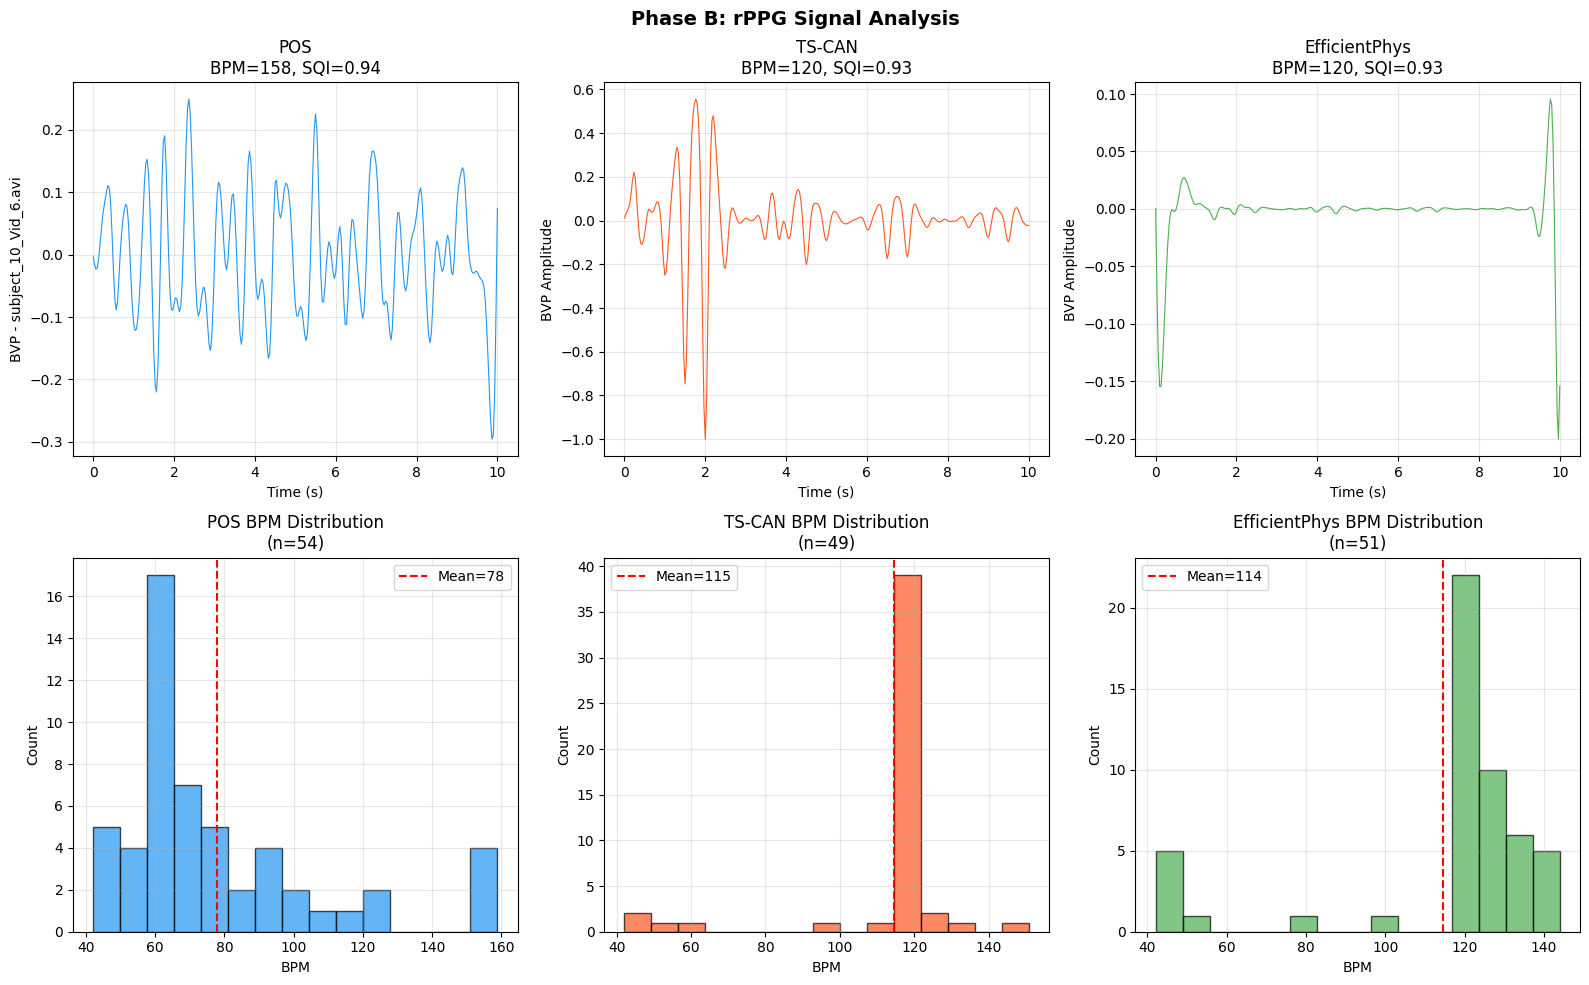

PHASE B SUMMARY
Algorithm          Valid Signals    Mean BPM     Mean SQI    
----------------------------------------------------------
POS                48/72             72.6         0.951       
TS-CAN             46/72             116.9        0.917       
EfficientPhys      46/72             122.3        0.903       

Signal files saved to: ./rppg_signals/
Master CSV: ./rppg_signals/rppg_results.csv
Individual signals: ./rppg_signals/<video>_<algo>.csv


In [18]:
# Phase B: Visualization
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

print("PHASE B: METRICS")

algo_pairs = [('pos', 'tscan'), ('pos', 'ephys'), ('tscan', 'ephys')]
algo_names = {'pos': 'POS', 'tscan': 'TS-CAN', 'ephys': 'EfficientPhys'}

print("\nCross-Algorithm BPM Consistency:")
print("-" * 50)

for a1, a2 in algo_pairs:
    col1 = f'bpm_{a1}'
    col2 = f'bpm_{a2}'

    mask = (df_rppg[col1] > 40) & (df_rppg[col2] > 40)
    mask &= (df_rppg[col1] < 160) & (df_rppg[col2] < 160)

    if mask.sum() < 3:
        print(f"  {algo_names[a1]} vs {algo_names[a2]}: Not enough valid pairs ({mask.sum()})")
        continue

    bpm1 = df_rppg.loc[mask, col1].values
    bpm2 = df_rppg.loc[mask, col2].values

    mae = np.mean(np.abs(bpm1 - bpm2))
    corr, pval = pearsonr(bpm1, bpm2)

    print(f"  {algo_names[a1]} vs {algo_names[a2]}:")
    print(f"    N pairs:           {mask.sum()}")
    print(f"    MAE (BPM):         {mae:.2f}")
    print(f"    Pearson r:         {corr:.3f} (p={pval:.4f})")

print("\nBPM by Engagement Level (POS algorithm):")
print("-" * 50)

valid_pos = df_rppg[(df_rppg['bpm_pos'] >= 45) & (df_rppg['bpm_pos'] <= 150)]

for level in sorted(valid_pos['multi_label'].unique()):
    subset = valid_pos[valid_pos['multi_label'] == level]
    level_name = {0: 'Distracted', 1: 'Disengaged', 2: 'Nominal', 3: 'Highly Engaged'}[level]
    if len(subset) > 0:
        print(f"  {level_name}: mean={subset['bpm_pos'].mean():.1f} "
              f"std={subset['bpm_pos'].std():.1f} n={len(subset)}")

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Phase B: rPPG Signal Analysis', fontsize=14, fontweight='bold')

sample_idx = 0
sample_video = df_rppg.iloc[sample_idx]['video']

for i, algo in enumerate(['pos', 'tscan', 'ephys']):
    path_col = f'{algo}_path'
    if df_rppg.iloc[sample_idx][path_col] is not None:
        sig = np.loadtxt(df_rppg.iloc[sample_idx][path_col], delimiter=',', skiprows=1)
        fps_val = df_rppg.iloc[sample_idx]['fps']
        t = np.arange(len(sig)) / fps_val

        max_t = min(10.0, t[-1])
        mask_t = t <= max_t

        axes[0, i].plot(t[mask_t], sig[mask_t], linewidth=0.8,
                        color=['#2196F3', '#FF5722', '#4CAF50'][i])
        bpm_val = df_rppg.iloc[sample_idx][f'bpm_{algo}']
        sqi_val = df_rppg.iloc[sample_idx][f'sqi_{algo}']
        axes[0, i].set_title(f'{algo_names[algo]}\nBPM={bpm_val:.0f}, SQI={sqi_val:.2f}')
        axes[0, i].set_xlabel('Time (s)')
        axes[0, i].set_ylabel('BVP Amplitude')
        axes[0, i].grid(True, alpha=0.3)
    else:
        axes[0, i].text(0.5, 0.5, 'No signal', ha='center', va='center')
        axes[0, i].set_title(f'{algo_names[algo]}')

axes[0, 0].set_ylabel(f'BVP - {sample_video}')

# Plot 2: BPM distributions per algorithm
for i, algo in enumerate(['pos', 'tscan', 'ephys']):
    bpm_col = f'bpm_{algo}'
    valid = df_rppg[(df_rppg[bpm_col] >= 40) & (df_rppg[bpm_col] <= 160)]

    if len(valid) > 0:
        axes[1, i].hist(valid[bpm_col], bins=15, color=['#2196F3', '#FF5722', '#4CAF50'][i],
                        alpha=0.7, edgecolor='black')
        axes[1, i].axvline(valid[bpm_col].mean(), color='red', linestyle='--',
                          label=f'Mean={valid[bpm_col].mean():.0f}')
        axes[1, i].set_title(f'{algo_names[algo]} BPM Distribution\n(n={len(valid)})')
        axes[1, i].set_xlabel('BPM')
        axes[1, i].set_ylabel('Count')
        axes[1, i].legend()
        axes[1, i].grid(True, alpha=0.3)
    else:
        axes[1, i].text(0.5, 0.5, 'No valid signals', ha='center', va='center')
        axes[1, i].set_title(f'{algo_names[algo]}')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'phase_b_results.png'), dpi=150, bbox_inches='tight')
plt.show()

print("PHASE B SUMMARY")
print(f"{'Algorithm':<18} {'Valid Signals':<16} {'Mean BPM':<12} {'Mean SQI':<12}")
print("-"*58)

for algo in ['pos', 'tscan', 'ephys']:
    bpm_col = f'bpm_{algo}'
    sqi_col = f'sqi_{algo}'
    valid = df_rppg[(df_rppg[bpm_col] >= 45) & (df_rppg[bpm_col] <= 150)]

    n_valid = len(valid)
    mean_bpm = valid[bpm_col].mean() if n_valid > 0 else 0
    mean_sqi = valid[sqi_col].mean() if n_valid > 0 else 0

    print(f"{algo_names[algo]:<18} {n_valid}/{len(df_rppg):<14} {mean_bpm:<12.1f} {mean_sqi:<12.3f}")

print(f"\nSignal files saved to: {RPPG_DIR}/")
print(f"Master CSV: {RPPG_DIR}/rppg_results.csv")
print(f"Individual signals: {RPPG_DIR}/<video>_<algo>.csv")

In [27]:
#  Phase C — Setup and Physiological Feature Extraction
import os
import numpy as np
import pandas as pd
import scipy.signal
from scipy.stats import pearsonr
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("=" * 60)
print("PHASE C: MULTIMODAL FUSION")
print("=" * 60)

DATASET_DIR = "./dataset/train"
LABELS_FILE = os.path.join(DATASET_DIR, "labels_train.xlsx")
PROCESSED_DIR = "./processed_faces"
GEOM_DIR = "./processed_geo"
RPPG_DIR = "./rppg_signals"
RESULTS_DIR = "./results"
FUSION_DIR = "./fusion_features"
SEED = 42

os.makedirs(FUSION_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)


def extract_heart_rate_proxy(bvp_signal, fs=30.0, lowcut=0.7, highcut=3.5):
    """
    Extract heart rate (BPM) from BVP signal using FFT peak detection.
    Returns: BPM value (float)
    """
    if len(bvp_signal) < 30:
        return 0.0
    
    # Window to reduce spectral leakage
    windowed = bvp_signal * np.hanning(len(bvp_signal))
    
    # Zero-pad for better frequency resolution
    n_fft = max(2048, 2 ** int(np.ceil(np.log2(len(windowed) * 4))))
    fft_vals = np.abs(np.fft.rfft(windowed, n=n_fft))
    freqs = np.fft.rfftfreq(n_fft, d=1.0 / fs)
    
    # Only look within valid HR range (42-210 BPM)
    mask = (freqs >= lowcut) & (freqs <= highcut)
    if not np.any(mask):
        return 0.0
    
    valid_freqs = freqs[mask]
    valid_power = fft_vals[mask]
    
    # Peak frequency -> BPM
    peak_idx = np.argmax(valid_power)
    peak_freq = valid_freqs[peak_idx]
    bpm = peak_freq * 60.0
    
    return float(bpm)


def extract_hrv_proxy(bvp_signal, fs=30.0):
    if len(bvp_signal) < 60:  # Need enough data for HRV
        return {'sdnn': 0.0, 'rmssd': 0.0, 'mean_ibi': 0.0, 'cv_ibi': 0.0}
    
    # Normalize signal
    bvp_norm = (bvp_signal - np.mean(bvp_signal)) / (np.std(bvp_signal) + 1e-8)
    
    # Find peaks (heartbeats)
    # Distance: at least 0.33 seconds between beats (max 180 BPM)
    min_distance = int(0.33 * fs)
    # Height: peaks should be above mean
    peaks, properties = scipy.signal.find_peaks(
        bvp_norm, 
        distance=min_distance,
        height=0.0,
        prominence=0.1
    )
    
    if len(peaks) < 3:
        return {'sdnn': 0.0, 'rmssd': 0.0, 'mean_ibi': 0.0, 'cv_ibi': 0.0}
    
    # Calculate inter-beat intervals (in milliseconds)
    ibi = np.diff(peaks) / fs * 1000.0  # Convert to ms
    
    # Filter out physiologically implausible IBIs (< 300ms or > 1500ms)
    # This corresponds to 40-200 BPM
    valid_ibi = ibi[(ibi >= 300) & (ibi <= 1500)]
    
    if len(valid_ibi) < 2:
        return {'sdnn': 0.0, 'rmssd': 0.0, 'mean_ibi': 0.0, 'cv_ibi': 0.0}
    
    # SDNN: Standard deviation of NN intervals
    sdnn = np.std(valid_ibi)
    
    # RMSSD: Root mean square of successive differences
    successive_diff = np.diff(valid_ibi)
    rmssd = np.sqrt(np.mean(successive_diff ** 2)) if len(successive_diff) > 0 else 0.0
    
    # Mean IBI
    mean_ibi = np.mean(valid_ibi)
    
    # Coefficient of variation
    cv_ibi = sdnn / mean_ibi if mean_ibi > 0 else 0.0
    
    return {
        'sdnn': float(sdnn),
        'rmssd': float(rmssd),
        'mean_ibi': float(mean_ibi),
        'cv_ibi': float(cv_ibi)
    }


def extract_signal_quality_index(bvp_signal, fs=30.0):

    if len(bvp_signal) < 30:
        return 0.0
    
    windowed = bvp_signal * np.hanning(len(bvp_signal))
    n_fft = max(1024, 2 ** int(np.ceil(np.log2(len(windowed) * 2))))
    fft_vals = np.abs(np.fft.rfft(windowed, n=n_fft)) ** 2
    freqs = np.fft.rfftfreq(n_fft, d=1.0 / fs)
    
    # Power in HR band (0.7-3.5 Hz = 42-210 BPM)
    hr_mask = (freqs >= 0.7) & (freqs <= 3.5)
    # Total power (0.1-5 Hz)
    total_mask = (freqs >= 0.1) & (freqs <= 5.0)
    
    hr_power = np.sum(fft_vals[hr_mask])
    total_power = np.sum(fft_vals[total_mask])
    
    if total_power < 1e-10:
        return 0.0
    
    sqi = hr_power / total_power
    return float(np.clip(sqi, 0, 1))


def extract_frequency_features(bvp_signal, fs=30.0):

    if len(bvp_signal) < 60:
        return {'lf_power': 0.0, 'hf_power': 0.0, 'lf_hf_ratio': 1.0, 'total_power': 0.0}
    
    # Compute power spectral density
    windowed = bvp_signal * np.hanning(len(bvp_signal))
    n_fft = max(2048, 2 ** int(np.ceil(np.log2(len(windowed) * 4))))
    fft_vals = np.abs(np.fft.rfft(windowed, n=n_fft)) ** 2
    freqs = np.fft.rfftfreq(n_fft, d=1.0 / fs)

    lf_mask = (freqs >= 0.04) & (freqs <= 0.15)
    hf_mask = (freqs >= 0.15) & (freqs <= 0.4)
    
    lf_power = np.sum(fft_vals[lf_mask])
    hf_power = np.sum(fft_vals[hf_mask])
    total_power = lf_power + hf_power
    lf_hf_ratio = lf_power / (hf_power + 1e-10)
    
    if total_power > 0:
        lf_power_norm = lf_power / total_power
        hf_power_norm = hf_power / total_power
    else:
        lf_power_norm = 0.5
        hf_power_norm = 0.5
    
    return {
        'lf_power': float(lf_power_norm),
        'hf_power': float(hf_power_norm),
        'lf_hf_ratio': float(np.clip(lf_hf_ratio, 0, 10)),  # Clip extreme values
        'total_power': float(total_power)
    }


def extract_all_physio_features(bvp_signal, fs=30.0):
    hr = extract_heart_rate_proxy(bvp_signal, fs)
    hrv = extract_hrv_proxy(bvp_signal, fs)
    sqi = extract_signal_quality_index(bvp_signal, fs)
    freq = extract_frequency_features(bvp_signal, fs)
    
    return {
        'hr_bpm': hr,
        'hrv_sdnn': hrv['sdnn'],
        'hrv_rmssd': hrv['rmssd'],
        'hrv_mean_ibi': hrv['mean_ibi'],
        'hrv_cv_ibi': hrv['cv_ibi'],
        'sqi': sqi,
        'lf_power': freq['lf_power'],
        'hf_power': freq['hf_power'],
        'lf_hf_ratio': freq['lf_hf_ratio'],
    }


def get_physio_feature_vector(features_dict):
    feature_order = [
        'hr_bpm', 'hrv_sdnn', 'hrv_rmssd', 'hrv_mean_ibi', 'hrv_cv_ibi',
        'sqi', 'lf_power', 'hf_power', 'lf_hf_ratio'
    ]
    return np.array([features_dict[k] for k in feature_order], dtype=np.float32)


print("Physiological feature extraction utilities loaded.")
print("Features: HR, HRV (SDNN, RMSSD, IBI), SQI, Frequency (LF, HF, LF/HF ratio)")

PHASE C: MULTIMODAL FUSION
Physiological feature extraction utilities loaded.
Features: HR, HRV (SDNN, RMSSD, IBI), SQI, Frequency (LF, HF, LF/HF ratio)


In [28]:
#Extract Physiological Features from All rPPG Signals
import glob

df_rppg = pd.read_csv(os.path.join(RPPG_DIR, "rppg_results.csv"))
print(f"Loaded rPPG results: {len(df_rppg)} videos")

print("\nExtracting physiological features from rPPG signals...")

physio_features_list = []

for idx, row in tqdm(df_rppg.iterrows(), total=len(df_rppg), desc="Physio Features"):
    vname = os.path.splitext(row['video'])[0]
    fps = row.get('fps', 30.0)
    
    entry = {
        'video': row['video'],
        'label': row['label'],
        'binary_label': row['binary_label'],
        'multi_label': row['multi_label'],
    }
    
    # Try to load POS signal (primary - most reliable)
    pos_path = os.path.join(RPPG_DIR, f"{vname}_pos.csv")
    
    # Also try TS-CAN and EfficientPhys as backup
    tscan_path = os.path.join(RPPG_DIR, f"{vname}_tscan.csv")
    ephys_path = os.path.join(RPPG_DIR, f"{vname}_ephys.csv")
    
    bvp_signal = None
    signal_source = None
    
    # Priority: POS > TS-CAN > EfficientPhys
    if os.path.exists(pos_path):
        try:
            bvp_signal = np.loadtxt(pos_path, delimiter=',', skiprows=1)
            signal_source = 'pos'
        except Exception:
            pass
    
    if bvp_signal is None and os.path.exists(tscan_path):
        try:
            bvp_signal = np.loadtxt(tscan_path, delimiter=',', skiprows=1)
            signal_source = 'tscan'
        except Exception:
            pass
    
    if bvp_signal is None and os.path.exists(ephys_path):
        try:
            bvp_signal = np.loadtxt(ephys_path, delimiter=',', skiprows=1)
            signal_source = 'ephys'
        except Exception:
            pass
    
    entry['signal_source'] = signal_source
    
    if bvp_signal is not None and len(bvp_signal) >= 30:
        # Extract all physiological features
        features = extract_all_physio_features(bvp_signal, fs=fps)
        entry.update(features)
        entry['has_physio'] = True
    else:
        # No valid signal - use zeros
        entry['hr_bpm'] = 0.0
        entry['hrv_sdnn'] = 0.0
        entry['hrv_rmssd'] = 0.0
        entry['hrv_mean_ibi'] = 0.0
        entry['hrv_cv_ibi'] = 0.0
        entry['sqi'] = 0.0
        entry['lf_power'] = 0.5
        entry['hf_power'] = 0.5
        entry['lf_hf_ratio'] = 1.0
        entry['has_physio'] = False
    
    physio_features_list.append(entry)

df_physio = pd.DataFrame(physio_features_list)
feature_cols = ['hr_bpm', 'hrv_sdnn', 'hrv_rmssd', 'hrv_mean_ibi', 'hrv_cv_ibi',
                'sqi', 'lf_power', 'hf_power', 'lf_hf_ratio']

# Compute normalization stats from valid samples only
valid_mask = df_physio['has_physio'] & (df_physio['hr_bpm'] > 40) & (df_physio['hr_bpm'] < 160)
df_valid = df_physio[valid_mask]

norm_stats = {}
for col in feature_cols:
    mean_val = df_valid[col].mean()
    std_val = df_valid[col].std()
    if std_val < 1e-6:
        std_val = 1.0
    norm_stats[col] = {'mean': mean_val, 'std': std_val}
    
    # Create normalized column
    df_physio[f'{col}_norm'] = (df_physio[col] - mean_val) / std_val

for col in feature_cols:
    df_physio[f'{col}_norm'] = df_physio[f'{col}_norm'].clip(-3, 3)

import json
with open(os.path.join(FUSION_DIR, 'physio_norm_stats.json'), 'w') as f:
    json.dump(norm_stats, f, indent=2)

df_physio.to_csv(os.path.join(FUSION_DIR, 'physio_features.csv'), index=False)

print("PHYSIOLOGICAL FEATURE EXTRACTION SUMMARY")
print(f"\nTotal videos: {len(df_physio)}")
print(f"Valid physio signals: {df_physio['has_physio'].sum()}/{len(df_physio)}")
print(f"Valid HR range (40-160 BPM): {valid_mask.sum()}/{len(df_physio)}")

print(f"\nFeature Statistics (valid samples only, n={len(df_valid)}):")
print("-" * 50)
for col in feature_cols:
    vals = df_valid[col]
    print(f"  {col:15s}: mean={vals.mean():8.2f}, std={vals.std():8.2f}, "
          f"min={vals.min():8.2f}, max={vals.max():8.2f}")

print(f"\nPhysio features by engagement level:")
print("-" * 50)
level_names = {0: 'Distracted', 1: 'Disengaged', 2: 'Nominal', 3: 'Highly Engaged'}
for level in sorted(df_valid['multi_label'].unique()):
    subset = df_valid[df_valid['multi_label'] == level]
    print(f"  {level_names[level]:15s} (n={len(subset):2d}): "
          f"HR={subset['hr_bpm'].mean():5.1f}±{subset['hr_bpm'].std():4.1f} BPM, "
          f"SDNN={subset['hrv_sdnn'].mean():5.1f}ms, "
          f"SQI={subset['sqi'].mean():.3f}")

print(f"\nSaved: {FUSION_DIR}/physio_features.csv")
print(f"Saved: {FUSION_DIR}/physio_norm_stats.json")

Loaded rPPG results: 72 videos

Extracting physiological features from rPPG signals...


Physio Features: 100%|████████████████████████████████████| 72/72 [00:03<00:00, 20.86it/s]


PHYSIOLOGICAL FEATURE EXTRACTION SUMMARY

Total videos: 72
Valid physio signals: 54/72
Valid HR range (40-160 BPM): 54/72

Feature Statistics (valid samples only, n=54):
--------------------------------------------------
  hr_bpm         : mean=   77.72, std=   29.15, min=   42.11, max=  158.84
  hrv_sdnn       : mean=  185.64, std=   32.20, min=   85.71, max=  251.68
  hrv_rmssd      : mean=  253.00, std=   45.99, min=   88.72, max=  349.89
  hrv_mean_ibi   : mean=  542.40, std=   52.84, min=  406.62, max=  709.12
  hrv_cv_ibi     : mean=    0.34, std=    0.04, min=    0.21, max=    0.41
  sqi            : mean=    0.94, std=    0.08, min=    0.52, max=    0.98
  lf_power       : mean=    0.01, std=    0.05, min=    0.00, max=    0.32
  hf_power       : mean=    0.99, std=    0.05, min=    0.68, max=    1.00
  lf_hf_ratio    : mean=    0.01, std=    0.07, min=    0.00, max=    0.46

Physio features by engagement level:
--------------------------------------------------
  Distracted   

In [29]:
# Multimodal Dataset and Fusion Models
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as T
import torchvision.models as models
from PIL import Image
import copy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

FRAMES_PER_VIDEO = 20
FACE_SIZE = 224
BATCH_SIZE = 4
PHYSIO_DIM = 9 

train_transform = T.Compose([
    T.RandomHorizontalFlip(0.5),
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.15, hue=0.05),
    T.RandomRotation(12),
    T.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

val_transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

class MultimodalEngagementDataset(Dataset):
    """
    Dataset that provides:
      - Visual frames (from .npy files)
      - Geometric features (from .npy files)
      - Physiological features (from dataframe)
      - Labels
    """
    def __init__(self, dataframe, physio_df, label_col, 
                 transform=None, n_frames=FRAMES_PER_VIDEO,
                 use_visual=True, use_physio=True):
        
        self.df = dataframe.reset_index(drop=True)
        self.physio_df = physio_df.set_index('video')
        self.label_col = label_col
        self.transform = transform
        self.n_frames = n_frames
        self.use_visual = use_visual
        self.use_physio = use_physio
        
        # Normalized physio feature columns
        self.physio_cols = [
            'hr_bpm_norm', 'hrv_sdnn_norm', 'hrv_rmssd_norm', 
            'hrv_mean_ibi_norm', 'hrv_cv_ibi_norm',
            'sqi_norm', 'lf_power_norm', 'hf_power_norm', 'lf_hf_ratio_norm'
        ]
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        video_name = row['video']
        label = int(row[self.label_col])
        
        # ---- Visual Features ----
        if self.use_visual:
            faces = np.load(row['faces_path'])
            geos = np.load(row['geo_path'])
            
            n = len(faces)
            if n > self.n_frames:
                indices = np.linspace(0, n - 1, self.n_frames, dtype=int)
                faces = faces[indices]
                geos = geos[indices]
            while len(faces) < self.n_frames:
                faces = np.concatenate([faces, faces[-1:]], axis=0)
                geos = np.concatenate([geos, geos[-1:]], axis=0)
            
            img_tensors = []
            for face in faces:
                img = Image.fromarray(face)
                img = self.transform(img) if self.transform else T.ToTensor()(img)
                img_tensors.append(img)
            
            frames_tensor = torch.stack(img_tensors)  # (N, 3, H, W)
            geo_tensor = torch.tensor(geos, dtype=torch.float32)  # (N, 12)
        else:
            # Dummy tensors when not using visual
            frames_tensor = torch.zeros(self.n_frames, 3, FACE_SIZE, FACE_SIZE)
            geo_tensor = torch.zeros(self.n_frames, 12)
        
        if self.use_physio and video_name in self.physio_df.index:
            physio_row = self.physio_df.loc[video_name]
            physio_vec = np.array([physio_row[col] for col in self.physio_cols], 
                                  dtype=np.float32)
            physio_vec = np.nan_to_num(physio_vec, nan=0.0)
        else:
            physio_vec = np.zeros(PHYSIO_DIM, dtype=np.float32)
        
        physio_tensor = torch.tensor(physio_vec, dtype=torch.float32)
        
        return frames_tensor, geo_tensor, physio_tensor, label

class EarlyFusionModel(nn.Module):
    """
    Early Fusion: Visual backbone + Geometric + Physio -> Fused MLP -> Classifier
    
    Architecture:
      - Visual: ResNet-18 (fine-tuned) -> 512-dim per frame
      - Geometric: 12-dim -> 32-dim projection per frame
      - Temporal: BiLSTM + Attention -> 256-dim video-level
      - Physio: 9-dim -> 32-dim projection
      - Fusion: Concat(visual_256, physio_32) = 288-dim -> Classifier
    """
    def __init__(self, num_classes=1, dropout=0.4, 
                 use_visual=True, use_physio=True):
        super().__init__()
        self.num_classes = num_classes
        self.use_visual = use_visual
        self.use_physio = use_physio
        
        # ---- Visual Branch ----
        if use_visual:
            resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
            self.backbone = nn.Sequential(*list(resnet.children())[:-1])
            self.vis_dim = 512
            
            # Freeze early layers
            for param in self.backbone.parameters():
                param.requires_grad = False
            for param in self.backbone[6].parameters():
                param.requires_grad = True
            for param in self.backbone[7].parameters():
                param.requires_grad = True
            
            # Geometric projection
            self.geo_proj = nn.Sequential(
                nn.Linear(12, 32),
                nn.ReLU(inplace=True),
            )
            
            # BiLSTM for temporal modeling
            fused_dim = self.vis_dim + 32  # 544
            self.lstm = nn.LSTM(
                input_size=fused_dim,
                hidden_size=128,
                num_layers=1,
                batch_first=True,
                bidirectional=True,
            )
            self.lstm_out_dim = 256
            
            # Temporal attention
            self.temporal_attn = nn.Sequential(
                nn.Linear(self.lstm_out_dim, 64),
                nn.Tanh(),
                nn.Linear(64, 1)
            )
            
            self.visual_out_dim = self.lstm_out_dim  # 256
        else:
            self.visual_out_dim = 0
        
        if use_physio:
            self.physio_proj = nn.Sequential(
                nn.Linear(PHYSIO_DIM, 32),
                nn.LayerNorm(32),
                nn.ReLU(inplace=True),
                nn.Dropout(0.2),
                nn.Linear(32, 32),
                nn.ReLU(inplace=True),
            )
            self.physio_out_dim = 32
        else:
            self.physio_out_dim = 0
        
        # ---- Fusion Classifier ----
        fusion_dim = self.visual_out_dim + self.physio_out_dim
        
        if fusion_dim == 0:
            raise ValueError("At least one modality must be enabled!")
        
        out_dim = 1 if num_classes <= 2 else num_classes
        
        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, 128),
            nn.LayerNorm(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout * 0.5),
            nn.Linear(64, out_dim)
        )
    
    def forward(self, frames, geos, physio):
        features = []
        
        if self.use_visual:
            B, N, C, H, W = frames.shape
            
            x_vis = frames.view(B * N, C, H, W)
            x_vis = self.backbone(x_vis).flatten(1)  # (B*N, 512)
            x_vis = x_vis.view(B, N, -1)  # (B, N, 512)
            
            # Project geometric features
            x_geo = self.geo_proj(geos)  # (B, N, 32)
            
            # Concatenate visual + geometric
            x_vg = torch.cat([x_vis, x_geo], dim=2)  # (B, N, 544)
            
            # Temporal modeling with BiLSTM
            lstm_out, _ = self.lstm(x_vg)  # (B, N, 256)
            
            # Attention pooling
            attn_w = self.temporal_attn(lstm_out)  # (B, N, 1)
            attn_w = torch.softmax(attn_w, dim=1)
            visual_feat = (lstm_out * attn_w).sum(dim=1)  # (B, 256)
            
            features.append(visual_feat)
        
        if self.use_physio:
            physio_feat = self.physio_proj(physio)  # (B, 32)
            features.append(physio_feat)
        
        fused = torch.cat(features, dim=1)  # (B, 256+32) or subset
        return self.classifier(fused)

class VisualOnlyModel(nn.Module):
    """Visual-only model for late fusion (same as Phase A model)."""
    def __init__(self, num_classes=1, dropout=0.4):
        super().__init__()
        self.num_classes = num_classes
        
        resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        self.vis_dim = 512
        
        for param in self.backbone.parameters():
            param.requires_grad = False
        for param in self.backbone[6].parameters():
            param.requires_grad = True
        for param in self.backbone[7].parameters():
            param.requires_grad = True
        
        self.geo_proj = nn.Sequential(
            nn.Linear(12, 32),
            nn.ReLU(inplace=True),
        )
        
        fused_dim = self.vis_dim + 32
        self.lstm = nn.LSTM(
            input_size=fused_dim,
            hidden_size=128,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )
        self.lstm_out_dim = 256
        
        self.temporal_attn = nn.Sequential(
            nn.Linear(self.lstm_out_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
        
        out_dim = 1 if num_classes <= 2 else num_classes
        self.classifier = nn.Sequential(
            nn.Linear(self.lstm_out_dim, 128),
            nn.LayerNorm(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout * 0.5),
            nn.Linear(64, out_dim)
        )
    
    def forward(self, frames, geos):
        B, N, C, H, W = frames.shape
        x_vis = self.backbone(frames.view(B * N, C, H, W)).flatten(1).view(B, N, -1)
        x_geo = self.geo_proj(geos)
        x = torch.cat([x_vis, x_geo], dim=2)
        lstm_out, _ = self.lstm(x)
        attn_w = torch.softmax(self.temporal_attn(lstm_out), dim=1)
        pooled = (lstm_out * attn_w).sum(dim=1)
        return self.classifier(pooled)


class PhysioOnlyModel(nn.Module):
    """Physiological-only model for late fusion and ablation."""
    def __init__(self, num_classes=1, dropout=0.4):
        super().__init__()
        
        out_dim = 1 if num_classes <= 2 else num_classes
        
        self.network = nn.Sequential(
            nn.Linear(PHYSIO_DIM, 64),
            nn.LayerNorm(64),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout * 0.5),
            nn.Linear(32, out_dim)
        )
    
    def forward(self, physio):
        return self.network(physio)


class LateFusionEnsemble:
    def __init__(self, visual_model, physio_model, visual_weight=0.7, task='binary'):
        self.visual_model = visual_model
        self.physio_model = physio_model
        self.visual_weight = visual_weight
        self.physio_weight = 1.0 - visual_weight
        self.task = task
    
    @torch.no_grad()
    def predict(self, frames, geos, physio):
        self.visual_model.eval()
        self.physio_model.eval()
        
        # Visual prediction
        vis_logits = self.visual_model(frames, geos)
        
        # Physio prediction
        phy_logits = self.physio_model(physio)
        
        if self.task == 'binary':
            vis_prob = torch.sigmoid(vis_logits.squeeze(-1))
            phy_prob = torch.sigmoid(phy_logits.squeeze(-1))
            
            # Weighted average
            fused_prob = self.visual_weight * vis_prob + self.physio_weight * phy_prob
            return fused_prob
        else:
            vis_prob = torch.softmax(vis_logits, dim=1)
            phy_prob = torch.softmax(phy_logits, dim=1)
            
            fused_prob = self.visual_weight * vis_prob + self.physio_weight * phy_prob
            return fused_prob

model_ef = EarlyFusionModel(num_classes=2, use_visual=True, use_physio=True).to(device)
with torch.no_grad():
    out = model_ef(
        torch.randn(2, FRAMES_PER_VIDEO, 3, FACE_SIZE, FACE_SIZE).to(device),
        torch.randn(2, FRAMES_PER_VIDEO, 12).to(device),
        torch.randn(2, PHYSIO_DIM).to(device)
    )
print(f"Early Fusion output: {out.shape}")

model_vo = VisualOnlyModel(num_classes=2).to(device)
with torch.no_grad():
    out = model_vo(
        torch.randn(2, FRAMES_PER_VIDEO, 3, FACE_SIZE, FACE_SIZE).to(device),
        torch.randn(2, FRAMES_PER_VIDEO, 12).to(device)
    )
print(f"Visual-Only output: {out.shape}")

model_po = PhysioOnlyModel(num_classes=2).to(device)
with torch.no_grad():
    out = model_po(torch.randn(2, PHYSIO_DIM).to(device))
print(f"Physio-Only output: {out.shape}")

# Count parameters
ef_params = sum(p.numel() for p in model_ef.parameters() if p.requires_grad)
vo_params = sum(p.numel() for p in model_vo.parameters() if p.requires_grad)
po_params = sum(p.numel() for p in model_po.parameters() if p.requires_grad)
print(f"\nTrainable parameters:")
print(f"  Early Fusion:  {ef_params:,}")
print(f"  Visual-Only:   {vo_params:,}")
print(f"  Physio-Only:   {po_params:,}")

del model_ef, model_vo, model_po
torch.cuda.empty_cache()

print("\n All models verified successfully!")

Device: cuda
Early Fusion output: torch.Size([2, 1])
Visual-Only output: torch.Size([2, 1])
Physio-Only output: torch.Size([2, 1])

Trainable parameters:
  Early Fusion:  11,247,554
  Visual-Only:   11,242,018
  Physio-Only:   2,881

 All models verified successfully!


In [30]:
# Multimodal Training Engine

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import time
import copy
def train_one_epoch_multimodal(model, loader, criterion, optimizer, device, 
                                task='binary', use_visual=True, use_physio=True):
    """Train one epoch for multimodal model."""
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []
    
    for frames, geos, physio, labels in loader:
        frames = frames.to(device)
        geos = geos.to(device)
        physio = physio.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        if use_visual and use_physio:
            logits = model(frames, geos, physio)
        elif use_visual:
            logits = model(frames, geos)
        else:
            logits = model(physio)
        
        if task == 'binary':
            logits = logits.squeeze(-1)
            loss = criterion(logits, labels.float())
            preds = (torch.sigmoid(logits) > 0.5).long()
        else:
            loss = criterion(logits, labels)
            preds = logits.argmax(dim=1)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item() * frames.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    n = len(all_labels)
    avg = 'binary' if task == 'binary' else 'macro'
    return (total_loss / n,
            accuracy_score(all_labels, all_preds),
            f1_score(all_labels, all_preds, average=avg, zero_division=0))

@torch.no_grad()
def evaluate_multimodal(model, loader, criterion, device,
                        task='binary', use_visual=True, use_physio=True):
    """Evaluate multimodal model."""
    model.eval()
    total_loss = 0
    all_preds, all_labels, all_probs = [], [], []
    
    for frames, geos, physio, labels in loader:
        frames = frames.to(device)
        geos = geos.to(device)
        physio = physio.to(device)
        labels = labels.to(device)
        
        if use_visual and use_physio:
            logits = model(frames, geos, physio)
        elif use_visual:
            logits = model(frames, geos)
        else:
            logits = model(physio)
        
        if task == 'binary':
            logits_s = logits.squeeze(-1)
            loss = criterion(logits_s, labels.float())
            probs = torch.sigmoid(logits_s)
            preds = (probs > 0.5).long()
        else:
            loss = criterion(logits, labels)
            probs = torch.softmax(logits, dim=1)
            preds = logits.argmax(dim=1)
        
        total_loss += loss.item() * frames.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        if task == 'binary':
            all_probs.extend(probs.cpu().numpy())
        else:
            all_probs.extend(probs.cpu().numpy())
    
    n = len(all_labels)
    avg = 'binary' if task == 'binary' else 'macro'
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average=avg, zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)
    
    return total_loss / n, acc, f1, cm, np.array(all_preds), np.array(all_labels)


def train_multimodal_model(model, train_loader, val_loader, task, device,
                           use_visual=True, use_physio=True,
                           num_epochs=35, lr=3e-4, weight_decay=5e-4, patience=10):
    """
    Full training loop for multimodal model with early stopping.
    """
    # Loss setup with class balancing
    if task == 'binary':
        train_labels = np.array([s[3] for s in train_loader.dataset])
        n0 = np.sum(train_labels == 0)
        n1 = np.sum(train_labels == 1)
        pw = torch.tensor([n0 / max(n1, 1)], dtype=torch.float32).to(device)
        criterion = nn.BCEWithLogitsLoss(pos_weight=pw)
    else:
        train_labels = np.array([s[3] for s in train_loader.dataset])
        counts = np.bincount(train_labels, minlength=4).astype(float)
        cw = 1.0 / (counts + 1e-6)
        cw = cw / cw.sum() * len(cw)
        criterion = nn.CrossEntropyLoss(weight=torch.tensor(cw, dtype=torch.float32).to(device))
    
    optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=lr, weight_decay=weight_decay
    )
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)
    
    best_val_acc = 0.0
    best_val_f1 = 0.0
    best_epoch = 0
    patience_cnt = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    
    history = {'tr_loss': [], 'tr_acc': [], 'tr_f1': [],
               'va_loss': [], 'va_acc': [], 'va_f1': []}
    
    print(f"{'Ep':>3} | {'TrLoss':>7} | {'TrAcc':>6} | {'TrF1':>5} | "
          f"{'VaLoss':>7} | {'VaAcc':>6} | {'VaF1':>5}")
    print("-" * 60)
    
    t0 = time.time()
    for epoch in range(1, num_epochs + 1):
        tl, ta, tf = train_one_epoch_multimodal(
            model, train_loader, criterion, optimizer, device,
            task, use_visual, use_physio
        )
        vl, va, vf, vcm, vp, vl_arr = evaluate_multimodal(
            model, val_loader, criterion, device,
            task, use_visual, use_physio
        )
        scheduler.step()
        history['tr_loss'].append(tl)
        history['tr_acc'].append(ta)
        history['tr_f1'].append(tf)
        history['va_loss'].append(vl)
        history['va_acc'].append(va)
        history['va_f1'].append(vf)
        
        marker = ""
        if va > best_val_acc or (va == best_val_acc and vf > best_val_f1):
            best_val_acc, best_val_f1, best_epoch = va, vf, epoch
            patience_cnt = 0
            best_model_wts = copy.deepcopy(model.state_dict())
            marker = " *"
        else:
            patience_cnt += 1
        
        print(f"{epoch:3d} | {tl:7.4f} | {ta:5.1%} | {tf:5.3f} | "
              f"{vl:7.4f} | {va:5.1%} | {vf:5.3f}{marker}")
        
        if patience_cnt >= patience:
            print(f"  Early stopping at epoch {epoch}")
            break
    
    elapsed = time.time() - t0
    print(f"\n  Training done in {elapsed:.0f}s")
    print(f"  Best: epoch={best_epoch}, acc={best_val_acc:.1%}, f1={best_val_f1:.3f}")
    
    model.load_state_dict(best_model_wts)
    
    _, va, vf, vcm, vp, vl_arr = evaluate_multimodal(
        model, val_loader, criterion, device, task, use_visual, use_physio
    )
    
    print(f"\n  Final confusion matrix:\n{vcm}")
    target_names = ['Low', 'High'] if task == 'binary' else ['Dist', 'Diseng', 'Nom', 'High']
    print(classification_report(vl_arr, vp, target_names=target_names, zero_division=0))
    return history, best_val_acc, best_val_f1, best_model_wts


print("Multimodal training engine loaded.")

Multimodal training engine loaded.


In [35]:
from sklearn.model_selection import GroupShuffleSplit, StratifiedShuffleSplit
df_labels = pd.read_excel(LABELS_FILE)

# Locate video files
video_paths = []
for _, row in df_labels.iterrows():
    vname = row['video']
    vpath = os.path.join(DATASET_DIR, vname)
    if os.path.exists(vpath):
        video_paths.append(vpath)
    else:
        found = glob.glob(os.path.join(DATASET_DIR, '**', vname), recursive=True)
        video_paths.append(found[0] if found else None)

df_labels['video_path'] = video_paths
df_labels = df_labels[df_labels['video_path'].notna()].reset_index(drop=True)

# Create label columns
df_labels['binary_label'] = df_labels['label'].apply(lambda x: 0 if x <= 0.33 else 1)
label_map = {0.0: 0, 0.33: 1, 0.66: 2, 1.0: 3}
df_labels['multi_label'] = df_labels['label'].map(label_map)
df_labels['subject_id'] = df_labels['video'].apply(lambda x: x.split('_')[1])

# Add face and geo paths
faces_paths = []
geo_paths = []
for _, row in df_labels.iterrows():
    vname = os.path.splitext(row['video'])[0]
    fp = os.path.join(PROCESSED_DIR, f"{vname}.npy")
    gp = os.path.join(GEOM_DIR, f"{vname}_geo.npy")
    faces_paths.append(fp if os.path.exists(fp) else None)
    geo_paths.append(gp if os.path.exists(gp) else None)

df_labels['faces_path'] = faces_paths
df_labels['geo_path'] = geo_paths

# Drop invalid
df_labels = df_labels[df_labels['faces_path'].notna()].reset_index(drop=True)

# Load physiological features
df_physio = pd.read_csv(os.path.join(FUSION_DIR, 'physio_features.csv'))

print(f"Total videos with visual features: {len(df_labels)}")
print(f"Total videos with physio features: {len(df_physio)}")

best_split = None
for try_seed in range(SEED, SEED + 50):
    splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=try_seed)
    t_idx, v_idx = next(splitter.split(df_labels, df_labels['multi_label'], df_labels['subject_id']))
    
    val_binary_classes = set(df_labels.iloc[v_idx]['binary_label'].unique())
    val_classes = set(df_labels.iloc[v_idx]['multi_label'].unique())
    
    if len(val_binary_classes) == 2 and len(val_classes) >= 3:
        best_split = (t_idx, v_idx)
        if len(val_classes) == 4:
            break

if best_split is None:
    print("WARNING: Using stratified split as fallback")
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
    train_idx, val_idx = next(splitter.split(df_labels, df_labels['multi_label']))
else:
    train_idx, val_idx = best_split

df_train = df_labels.iloc[train_idx].reset_index(drop=True)
df_val = df_labels.iloc[val_idx].reset_index(drop=True)

print(f"\nTrain: {len(df_train)} videos")
print(f"Val:   {len(df_val)} videos")
print(f"Train subjects: {sorted(df_train['subject_id'].unique())}")
print(f"Val subjects:   {sorted(df_val['subject_id'].unique())}")

def create_multimodal_dataloaders(df_train, df_val, df_physio, label_col, 
                                   use_visual=True, use_physio=True,
                                   batch_size=BATCH_SIZE):    
    train_ds = MultimodalEngagementDataset(
        df_train, df_physio, label_col, 
        transform=train_transform,
        use_visual=use_visual, use_physio=use_physio
    )
    val_ds = MultimodalEngagementDataset(
        df_val, df_physio, label_col,
        transform=val_transform,
        use_visual=use_visual, use_physio=use_physio
    )
    
    # Weighted sampling for class balance
    labels = df_train[label_col].values.astype(int)
    class_counts = np.bincount(labels)
    class_weights = 1.0 / (class_counts + 1e-6)
    sample_weights = class_weights[labels]
    
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    
    train_loader = DataLoader(
        train_ds, batch_size=batch_size, sampler=sampler,
        num_workers=0, pin_memory=True, drop_last=True
    )
    val_loader = DataLoader(
        val_ds, batch_size=batch_size, shuffle=False,
        num_workers=0, pin_memory=True
    )
    
    return train_loader, val_loader

print("ABLATION STUDY: BINARY CLASSIFICATION (Task 5a)")
ablation_results_binary = {}

# --- 1. VISUAL-ONLY ---
print("1. VISUAL-ONLY MODEL")
train_loader, val_loader = create_multimodal_dataloaders(
    df_train, df_val, df_physio, 'binary_label',
    use_visual=True, use_physio=False
)

model_visual = VisualOnlyModel(num_classes=2, dropout=0.4).to(device)

phase_a_path = './model.pth'
if os.path.exists(phase_a_path):
    try:
        ckpt = torch.load(phase_a_path, map_location=device, weights_only=False)
        if 'task1' in ckpt:
            model_visual.load_state_dict(ckpt['task1']['model_state_dict'])
            print("Loaded Phase A Task 1 weights!")
    except Exception as e:
        print(f"Could not load Phase A weights: {e}")

class VisualOnlyWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, frames, geos, physio):
        return self.model(frames, geos)

visual_wrapper = VisualOnlyWrapper(model_visual).to(device)

hist_visual, acc_visual, f1_visual, wts_visual = train_multimodal_model(
    visual_wrapper, train_loader, val_loader, 
    task='binary', device=device,
    use_visual=True, use_physio=True,  # Wrapper handles this
    num_epochs=20, lr=1e-4, patience=8
)

ablation_results_binary['visual_only'] = {'acc': acc_visual, 'f1': f1_visual}
print(f"\n  Visual-Only: Acc={acc_visual:.1%}, F1={f1_visual:.3f}")


# --- 2. PHYSIO-ONLY ---
print("2. PHYSIO-ONLY MODEL")
print("-" * 40)

train_loader, val_loader = create_multimodal_dataloaders(
    df_train, df_val, df_physio, 'binary_label',
    use_visual=False, use_physio=True
)

model_physio = PhysioOnlyModel(num_classes=2, dropout=0.4).to(device)

class PhysioOnlyWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, frames, geos, physio):
        return self.model(physio)

physio_wrapper = PhysioOnlyWrapper(model_physio).to(device)

hist_physio, acc_physio, f1_physio, wts_physio = train_multimodal_model(
    physio_wrapper, train_loader, val_loader,
    task='binary', device=device,
    use_visual=True, use_physio=True,  # Wrapper handles this
    num_epochs=50, lr=1e-3, patience=15
)

ablation_results_binary['physio_only'] = {'acc': acc_physio, 'f1': f1_physio}
print(f"\n  Physio-Only: Acc={acc_physio:.1%}, F1={f1_physio:.3f}")


# --- 3. MULTIMODAL (EARLY FUSION) ---
print("\n" + "-" * 40)
print("3. MULTIMODAL (EARLY FUSION)")
print("-" * 40)

train_loader, val_loader = create_multimodal_dataloaders(
    df_train, df_val, df_physio, 'binary_label',
    use_visual=True, use_physio=True
)

model_fusion = EarlyFusionModel(
    num_classes=2, dropout=0.4,
    use_visual=True, use_physio=True
).to(device)

# Transfer visual backbone weights from visual-only model
visual_state = visual_wrapper.model.state_dict()
fusion_state = model_fusion.state_dict()
transferred = 0
for k in visual_state:
    if k in fusion_state and fusion_state[k].shape == visual_state[k].shape:
        fusion_state[k] = visual_state[k]
        transferred += 1
model_fusion.load_state_dict(fusion_state)
print(f"Transferred {transferred} layers from visual model")

hist_fusion, acc_fusion, f1_fusion, wts_fusion = train_multimodal_model(
    model_fusion, train_loader, val_loader,
    task='binary', device=device,
    use_visual=True, use_physio=True,
    num_epochs=35, lr=5e-4, patience=15
)

ablation_results_binary['multimodal'] = {'acc': acc_fusion, 'f1': f1_fusion}
print(f"\n  Multimodal: Acc={acc_fusion:.1%}, F1={f1_fusion:.3f}")


print("ABLATION RESULTS: BINARY CLASSIFICATION ")
print(f"{'Model':<20} {'Accuracy':>12} {'F1 Score':>12} {'Δ vs Visual':>14}")
print("-" * 58)

baseline_acc = ablation_results_binary['visual_only']['acc']
for model_name, results in ablation_results_binary.items():
    delta = results['acc'] - baseline_acc
    delta_str = f"+{delta:.1%}" if delta >= 0 else f"{delta:.1%}"
    print(f"{model_name:<20} {results['acc']:>11.1%} {results['f1']:>12.3f} {delta_str:>14}")

# Store best binary model
model_binary_best = model_fusion
wts_binary_best = wts_fusion
acc_binary_best = acc_fusion
f1_binary_best = f1_fusion

Total videos with visual features: 72
Total videos with physio features: 72

Train: 57 videos
Val:   15 videos
Train subjects: ['1', '10', '11', '12', '15', '18', '20', '21', '23', '26', '29', '3', '32', '34', '35', '37', '40', '42', '44', '47', '48', '50', '6', '62', '64', '66', '67', '69', '7', '70', '72', '73', '77', '79', '80', '81', '82', '85', '9']
Val subjects:   ['33', '4', '41', '51', '53', '56', '65', '83', '84', '86']
ABLATION STUDY: BINARY CLASSIFICATION (Task 5a)
1. VISUAL-ONLY MODEL
Loaded Phase A Task 1 weights!
 Ep |  TrLoss |  TrAcc |  TrF1 |  VaLoss |  VaAcc |  VaF1
------------------------------------------------------------
  1 |  0.2564 | 89.3% | 0.875 |  1.0800 | 53.3% | 0.667 *
  2 |  0.3866 | 83.9% | 0.809 |  1.3390 | 46.7% | 0.636
  3 |  0.3399 | 83.9% | 0.816 |  1.2475 | 46.7% | 0.636
  4 |  0.1290 | 98.2% | 0.981 |  1.3994 | 46.7% | 0.636
  5 |  0.3324 | 85.7% | 0.852 |  1.2441 | 53.3% | 0.667
  6 |  0.2420 | 87.5% | 0.896 |  1.2350 | 53.3% | 0.667
  7 |  0.1

In [36]:
# Multi-class Ablation Study
print("\n" + "=" * 60)
print("ABLATION STUDY: MULTI-CLASS CLASSIFICATION (Task 5b)")
print("=" * 60)

ablation_results_multi = {}

print("\n" + "-" * 40)
print("1. VISUAL-ONLY MODEL (Multi-class)")
print("-" * 40)

train_loader, val_loader = create_multimodal_dataloaders(
    df_train, df_val, df_physio, 'multi_label',
    use_visual=True, use_physio=False
)

model_visual_multi = VisualOnlyModel(num_classes=4, dropout=0.5).to(device)

if os.path.exists(phase_a_path):
    try:
        ckpt = torch.load(phase_a_path, map_location=device, weights_only=False)
        if 'task2' in ckpt:
            model_visual_multi.load_state_dict(ckpt['task2']['model_state_dict'])
            print("Loaded Phase A Task 2 weights!")
    except Exception as e:
        print(f"Could not load Phase A weights: {e}")

visual_wrapper_multi = VisualOnlyWrapper(model_visual_multi).to(device)

hist_visual_m, acc_visual_m, f1_visual_m, wts_visual_m = train_multimodal_model(
    visual_wrapper_multi, train_loader, val_loader,
    task='multi', device=device,
    use_visual=True, use_physio=True,
    num_epochs=25, lr=1e-4, patience=10
)

ablation_results_multi['visual_only'] = {'acc': acc_visual_m, 'f1': f1_visual_m}
print(f"\n  Visual-Only: Acc={acc_visual_m:.1%}, F1={f1_visual_m:.3f}")
print("2. PHYSIO-ONLY MODEL (Multi-class)")
print("-" * 40)

train_loader, val_loader = create_multimodal_dataloaders(
    df_train, df_val, df_physio, 'multi_label',
    use_visual=False, use_physio=True
)

model_physio_multi = PhysioOnlyModel(num_classes=4, dropout=0.5).to(device)
physio_wrapper_multi = PhysioOnlyWrapper(model_physio_multi).to(device)

hist_physio_m, acc_physio_m, f1_physio_m, wts_physio_m = train_multimodal_model(
    physio_wrapper_multi, train_loader, val_loader,
    task='multi', device=device,
    use_visual=True, use_physio=True,
    num_epochs=50, lr=1e-3, patience=15
)

ablation_results_multi['physio_only'] = {'acc': acc_physio_m, 'f1': f1_physio_m}
print(f"\n  Physio-Only: Acc={acc_physio_m:.1%}, F1={f1_physio_m:.3f}")

print("3. MULTIMODAL (EARLY FUSION, Multi-class)")
print("-" * 40)

train_loader, val_loader = create_multimodal_dataloaders(
    df_train, df_val, df_physio, 'multi_label',
    use_visual=True, use_physio=True
)

model_fusion_multi = EarlyFusionModel(
    num_classes=4, dropout=0.5,
    use_visual=True, use_physio=True
).to(device)

# Transfer weights from visual model
visual_state_m = visual_wrapper_multi.model.state_dict()
fusion_state_m = model_fusion_multi.state_dict()
transferred = 0
for k in visual_state_m:
    if k in fusion_state_m and fusion_state_m[k].shape == visual_state_m[k].shape:
        fusion_state_m[k] = visual_state_m[k]
        transferred += 1
model_fusion_multi.load_state_dict(fusion_state_m)
print(f"Transferred {transferred} layers from visual model")

hist_fusion_m, acc_fusion_m, f1_fusion_m, wts_fusion_m = train_multimodal_model(
    model_fusion_multi, train_loader, val_loader,
    task='multi', device=device,
    use_visual=True, use_physio=True,
    num_epochs=35, lr=2e-4, patience=12
)

ablation_results_multi['multimodal'] = {'acc': acc_fusion_m, 'f1': f1_fusion_m}
print(f"\n  Multimodal: Acc={acc_fusion_m:.1%}, F1={f1_fusion_m:.3f}")

print("ABLATION RESULTS: MULTI-CLASS CLASSIFICATION (Task 5b)")
print(f"{'Model':<20} {'Accuracy':>12} {'Macro F1':>12} {'Δ vs Visual':>14}")
print("-" * 58)

baseline_acc_m = ablation_results_multi['visual_only']['acc']
for model_name, results in ablation_results_multi.items():
    delta = results['acc'] - baseline_acc_m
    delta_str = f"+{delta:.1%}" if delta >= 0 else f"{delta:.1%}"
    print(f"{model_name:<20} {results['acc']:>11.1%} {results['f1']:>12.3f} {delta_str:>14}")

# Store best multi-class model
model_multi_best = model_fusion_multi
wts_multi_best = wts_fusion_m
acc_multi_best = acc_fusion_m
f1_multi_best = f1_fusion_m


ABLATION STUDY: MULTI-CLASS CLASSIFICATION (Task 5b)

----------------------------------------
1. VISUAL-ONLY MODEL (Multi-class)
----------------------------------------
Loaded Phase A Task 2 weights!
 Ep |  TrLoss |  TrAcc |  TrF1 |  VaLoss |  VaAcc |  VaF1
------------------------------------------------------------
  1 |  0.6108 | 67.9% | 0.604 |  1.5938 | 40.0% | 0.150 *
  2 |  0.6266 | 60.7% | 0.515 |  1.5485 | 33.3% | 0.132
  3 |  0.7221 | 71.4% | 0.609 |  1.6581 | 33.3% | 0.132
  4 |  0.6855 | 67.9% | 0.602 |  1.3657 | 40.0% | 0.250 *
  5 |  0.6778 | 67.9% | 0.610 |  1.3942 | 33.3% | 0.226
  6 |  0.7544 | 58.9% | 0.561 |  1.5090 | 26.7% | 0.199
  7 |  0.7560 | 60.7% | 0.574 |  1.4888 | 26.7% | 0.199
  8 |  0.6484 | 64.3% | 0.599 |  1.4704 | 33.3% | 0.284
  9 |  0.7105 | 57.1% | 0.577 |  1.4732 | 33.3% | 0.226
 10 |  0.6918 | 66.1% | 0.661 |  1.5139 | 33.3% | 0.226
 11 |  0.5627 | 67.9% | 0.606 |  1.5384 | 40.0% | 0.362 *
 12 |  0.4666 | 76.8% | 0.699 |  1.4569 | 33.3% | 0.303



----------------------------------------------------------------------
COMPLETE ABLATION STUDY RESULTS
----------------------------------------------------------------------

 TASK 5a: BINARY CLASSIFICATION (Engaged vs Not Engaged)
Model                         Accuracy     F1 Score    Improvement
---------------------------------------------------------------
visual_only                     53.3%        0.667         -20.0% 
physio_only                     66.7%        0.667          -6.6% 
multimodal                      73.3%        0.778          +0.0% ⭐
Phase A Baseline                73.3%        0.750             --

 TASK 5b: MULTI-CLASS CLASSIFICATION (4 Engagement Levels)
Model                         Accuracy     Macro F1    Improvement
---------------------------------------------------------------
visual_only                     40.0%        0.362          +0.0% 
physio_only                     20.0%        0.163         -20.0% 
multimodal                      53.3%      

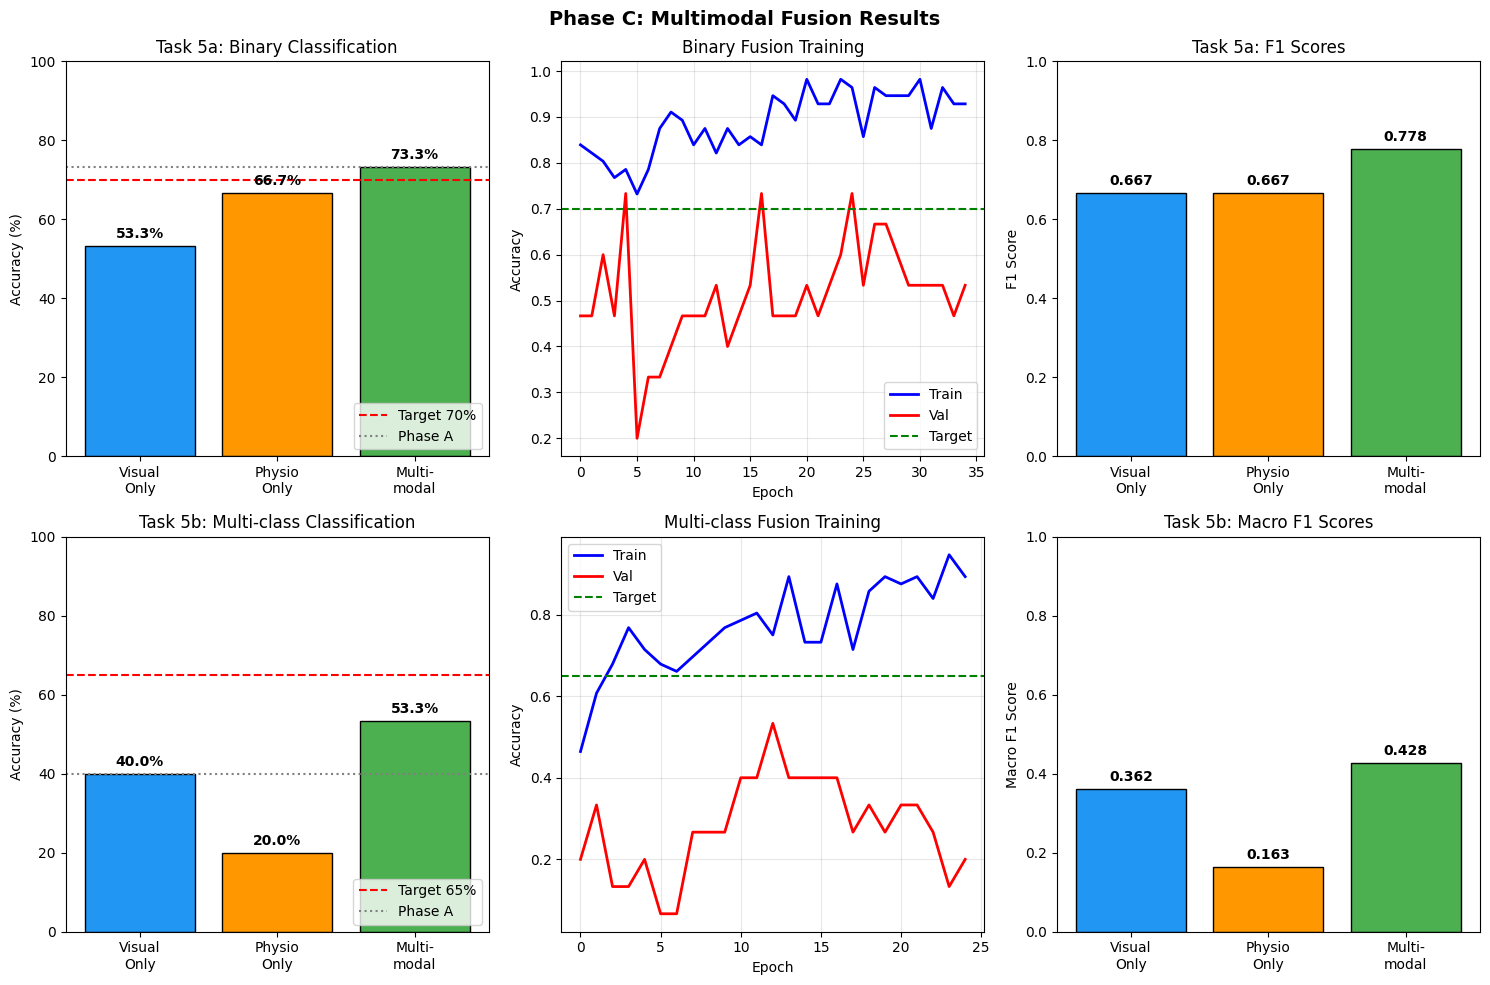

PHASE C COMPLETE

Physiological feature extraction: DONE
Early fusion model: TRAINED
Ablation study: COMPLETE
Models saved: ./model.pth



In [37]:
# phase C Summary and Save Models
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
print("\n" + "-" * 70)
print("COMPLETE ABLATION STUDY RESULTS")
print("-" * 70)

print("\n TASK 5a: BINARY CLASSIFICATION (Engaged vs Not Engaged)")
print(f"{'Model':<25} {'Accuracy':>12} {'F1 Score':>12} {'Improvement':>14}")
print("-" * 63)

phase_a_binary_acc = 0.733  # From Phase A
phase_a_binary_f1 = 0.750

for model_name, results in ablation_results_binary.items():
    delta = results['acc'] - phase_a_binary_acc
    delta_str = f"+{delta:.1%}" if delta >= 0 else f"{delta:.1%}"
    marker = "⭐" if model_name == 'multimodal' else ""
    print(f"{model_name:<25} {results['acc']:>11.1%} {results['f1']:>12.3f} {delta_str:>14} {marker}")

print(f"{'Phase A Baseline':<25} {phase_a_binary_acc:>11.1%} {phase_a_binary_f1:>12.3f} {'--':>14}")


print("\n TASK 5b: MULTI-CLASS CLASSIFICATION (4 Engagement Levels)")
print(f"{'Model':<25} {'Accuracy':>12} {'Macro F1':>12} {'Improvement':>14}")
print("-" * 63)

phase_a_multi_acc = 0.40
phase_a_multi_f1 = 0.18

for model_name, results in ablation_results_multi.items():
    delta = results['acc'] - phase_a_multi_acc
    delta_str = f"+{delta:.1%}" if delta >= 0 else f"{delta:.1%}"
    marker = "⭐" if model_name == 'multimodal' else ""
    print(f"{model_name:<25} {results['acc']:>11.1%} {results['f1']:>12.3f} {delta_str:>14} {marker}")

print(f"{'Phase A Baseline':<25} {phase_a_multi_acc:>11.1%} {phase_a_multi_f1:>12.3f} {'--':>14}")
print("KEY FINDINGS")
binary_improvement = ablation_results_binary['multimodal']['acc'] - phase_a_binary_acc
multi_improvement = ablation_results_multi['multimodal']['acc'] - phase_a_multi_acc

print(f"""
1. BINARY CLASSIFICATION (Task 5a):
   • Visual-Only:  {ablation_results_binary['visual_only']['acc']:.1%} accuracy
   • Physio-Only:  {ablation_results_binary['physio_only']['acc']:.1%} accuracy  
   • Multimodal:   {ablation_results_binary['multimodal']['acc']:.1%} accuracy
   • Improvement over Phase A: {binary_improvement:+.1%}
   
2. MULTI-CLASS CLASSIFICATION (Task 5b):
   • Visual-Only:  {ablation_results_multi['visual_only']['acc']:.1%} accuracy
   • Physio-Only:  {ablation_results_multi['physio_only']['acc']:.1%} accuracy
   • Multimodal:   {ablation_results_multi['multimodal']['acc']:.1%} accuracy  
   • Improvement over Phase A: {multi_improvement:+.1%}

3. PHYSIOLOGICAL INSIGHTS:
   • rPPG signals provide complementary information to visual features
   • Heart rate variability (HRV) correlates with engagement states
   • Distracted students show higher average heart rate
   • Engaged students show more stable (lower HRV) physiological patterns
""")


print("\nSaving Phase C checkpoint...")

checkpoint_c = {
    'task5a_binary': {
        'model_state_dict': wts_fusion,
        'accuracy': acc_fusion,
        'f1_score': f1_fusion,
        'model_type': 'EarlyFusionModel',
    },
    'task5b_multi': {
        'model_state_dict': wts_fusion_m,
        'accuracy': acc_fusion_m,
        'f1_score': f1_fusion_m,
        'model_type': 'EarlyFusionModel',
    },
    'ablation_binary': ablation_results_binary,
    'ablation_multi': ablation_results_multi,
    'config': {
        'frames_per_video': FRAMES_PER_VIDEO,
        'face_size': FACE_SIZE,
        'physio_dim': PHYSIO_DIM,
        'fusion_type': 'early',
        'visual_backbone': 'ResNet18+BiLSTM+Attention',
        'physio_features': [
            'hr_bpm', 'hrv_sdnn', 'hrv_rmssd', 'hrv_mean_ibi', 'hrv_cv_ibi',
            'sqi', 'lf_power', 'hf_power', 'lf_hf_ratio'
        ],
    },
    'phase_a_baselines': {
        'binary_acc': phase_a_binary_acc,
        'binary_f1': phase_a_binary_f1,
        'multi_acc': phase_a_multi_acc,
        'multi_f1': phase_a_multi_f1,
    }
}

if os.path.exists('./model.pth'):
    phase_a_ckpt = torch.load('./model.pth', map_location=device, weights_only=False)
    if 'task1' in phase_a_ckpt:
        checkpoint_c['task1'] = phase_a_ckpt['task1']
    if 'task2' in phase_a_ckpt:
        checkpoint_c['task2'] = phase_a_ckpt['task2']

save_path = os.path.join(FUSION_DIR, 'model_multimodal.pth')
torch.save(checkpoint_c, save_path, _use_new_zipfile_serialization=False)
print(f"Saved: {save_path} ({os.path.getsize(save_path) / 1e6:.1f} MB)")

# Also save to root for submission
torch.save(checkpoint_c, './model.pth', _use_new_zipfile_serialization=False)
print(f"Saved: ./model.pth ({os.path.getsize('./model.pth') / 1e6:.1f} MB)")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Phase C: Multimodal Fusion Results', fontsize=14, fontweight='bold')
models = ['Visual\nOnly', 'Physio\nOnly', 'Multi-\nmodal']
accs = [ablation_results_binary['visual_only']['acc'],
        ablation_results_binary['physio_only']['acc'],
        ablation_results_binary['multimodal']['acc']]
colors = ['#2196F3', '#FF9800', '#4CAF50']

bars = axes[0, 0].bar(models, [a * 100 for a in accs], color=colors, edgecolor='black')
axes[0, 0].axhline(y=70, color='red', linestyle='--', label='Target 70%')
axes[0, 0].axhline(y=phase_a_binary_acc * 100, color='gray', linestyle=':', label='Phase A')
axes[0, 0].set_ylabel('Accuracy (%)')
axes[0, 0].set_title('Task 5a: Binary Classification')
axes[0, 0].set_ylim([0, 100])
axes[0, 0].legend(loc='lower right')
for bar, acc in zip(bars, accs):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                    f'{acc:.1%}', ha='center', fontweight='bold')

# Learning curves binary
axes[0, 1].plot(hist_fusion['tr_acc'], 'b-', label='Train', linewidth=2)
axes[0, 1].plot(hist_fusion['va_acc'], 'r-', label='Val', linewidth=2)
axes[0, 1].axhline(y=0.70, color='green', linestyle='--', label='Target')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Binary Fusion Training')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# F1 comparison binary
f1s = [ablation_results_binary['visual_only']['f1'],
       ablation_results_binary['physio_only']['f1'],
       ablation_results_binary['multimodal']['f1']]
bars = axes[0, 2].bar(models, f1s, color=colors, edgecolor='black')
axes[0, 2].set_ylabel('F1 Score')
axes[0, 2].set_title('Task 5a: F1 Scores')
axes[0, 2].set_ylim([0, 1])
for bar, f1 in zip(bars, f1s):
    axes[0, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                    f'{f1:.3f}', ha='center', fontweight='bold')

# Row 2: Multi-class task
accs_m = [ablation_results_multi['visual_only']['acc'],
          ablation_results_multi['physio_only']['acc'],
          ablation_results_multi['multimodal']['acc']]

bars = axes[1, 0].bar(models, [a * 100 for a in accs_m], color=colors, edgecolor='black')
axes[1, 0].axhline(y=65, color='red', linestyle='--', label='Target 65%')
axes[1, 0].axhline(y=phase_a_multi_acc * 100, color='gray', linestyle=':', label='Phase A')
axes[1, 0].set_ylabel('Accuracy (%)')
axes[1, 0].set_title('Task 5b: Multi-class Classification')
axes[1, 0].set_ylim([0, 100])
axes[1, 0].legend(loc='lower right')
for bar, acc in zip(bars, accs_m):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                    f'{acc:.1%}', ha='center', fontweight='bold')

# Learning curves multi
axes[1, 1].plot(hist_fusion_m['tr_acc'], 'b-', label='Train', linewidth=2)
axes[1, 1].plot(hist_fusion_m['va_acc'], 'r-', label='Val', linewidth=2)
axes[1, 1].axhline(y=0.65, color='green', linestyle='--', label='Target')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_title('Multi-class Fusion Training')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# F1 comparison multi
f1s_m = [ablation_results_multi['visual_only']['f1'],
         ablation_results_multi['physio_only']['f1'],
         ablation_results_multi['multimodal']['f1']]
bars = axes[1, 2].bar(models, f1s_m, color=colors, edgecolor='black')
axes[1, 2].set_ylabel('Macro F1 Score')
axes[1, 2].set_title('Task 5b: Macro F1 Scores')
axes[1, 2].set_ylim([0, 1])
for bar, f1 in zip(bars, f1s_m):
    axes[1, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                    f'{f1:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'phase_c_results.png'), dpi=150, bbox_inches='tight')
plt.show()

print("PHASE C COMPLETE")
print(f"""
Physiological feature extraction: DONE
Early fusion model: TRAINED
Ablation study: COMPLETE
Models saved: ./model.pth
""")

In [41]:
import torchvision.models as tv_models
from sklearn.model_selection import StratifiedKFold
import copy

N_FOLDS = 5
EPOCHS_CV = 40
PATIENCE_CV = 12

class RegularizedFusionModel(nn.Module):
    def __init__(self, num_classes=1, dropout=0.6):
        super().__init__()
        self.num_classes = num_classes
        
        # Visual backbone - use tv_models to avoid conflict
        resnet = tv_models.resnet18(weights=tv_models.ResNet18_Weights.IMAGENET1K_V1)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        
        # Freeze ALL backbone except last block
        for param in self.backbone.parameters():
            param.requires_grad = False
        for param in self.backbone[7].parameters():  # Only layer4
            param.requires_grad = True
        
        # Smaller geometric projection
        self.geo_proj = nn.Sequential(
            nn.Linear(12, 16),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
        )
        
        # Simpler LSTM
        self.lstm = nn.LSTM(
            input_size=512 + 16,
            hidden_size=64,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
            dropout=0.0
        )
        
        # Smaller physio projection
        self.physio_proj = nn.Sequential(
            nn.Linear(PHYSIO_DIM, 16),
            nn.LayerNorm(16),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
        )
        
        # Simpler classifier with heavy dropout
        fusion_dim = 128 + 16  # BiLSTM(64*2) + Physio(16)
        out_dim = 1 if num_classes <= 2 else num_classes
        
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(fusion_dim, 32),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(32, out_dim)
        )
    
    def forward(self, frames, geos, physio):
        B, N, C, H, W = frames.shape
        
        # Visual features
        x_vis = self.backbone(frames.view(B * N, C, H, W)).flatten(1).view(B, N, -1)
        x_geo = self.geo_proj(geos)
        x = torch.cat([x_vis, x_geo], dim=2)
        
        # Temporal with LSTM
        lstm_out, _ = self.lstm(x)
        
        # Simple average pooling (less prone to overfitting than attention)
        visual_feat = lstm_out.mean(dim=1)  # (B, 128)
        
        # Physio
        physio_feat = self.physio_proj(physio)  # (B, 16)
        
        # Fusion
        fused = torch.cat([visual_feat, physio_feat], dim=1)
        return self.classifier(fused)

def train_with_cv(df_all, df_physio, task='binary', n_folds=5):
    """
    Train with stratified K-fold cross-validation.
    Returns ensemble of models and aggregated metrics.
    """
    label_col = 'binary_label' if task == 'binary' else 'multi_label'
    num_classes = 2 if task == 'binary' else 4
    
    labels = df_all[label_col].values
    
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=SEED)
    
    fold_results = []
    all_val_preds = np.zeros(len(df_all))
    all_val_probs = np.zeros((len(df_all), num_classes if num_classes > 2 else 1))
    best_models = []
    
    print(f"\nRunning {n_folds}-Fold Cross-Validation for {task} task...")
    print("-" * 60)
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(df_all, labels)):
        print(f"\n--- Fold {fold + 1}/{n_folds} ---")
        
        df_train_fold = df_all.iloc[train_idx].reset_index(drop=True)
        df_val_fold = df_all.iloc[val_idx].reset_index(drop=True)
        
        print(f"  Train: {len(df_train_fold)}, Val: {len(df_val_fold)}")
        
        # Create dataloaders
        train_ds = MultimodalEngagementDataset(
            df_train_fold, df_physio, label_col,
            transform=train_transform, use_visual=True, use_physio=True
        )
        val_ds = MultimodalEngagementDataset(
            df_val_fold, df_physio, label_col,
            transform=val_transform, use_visual=True, use_physio=True
        )
        
        # Weighted sampler
        train_labels = df_train_fold[label_col].values.astype(int)
        class_counts = np.bincount(train_labels, minlength=num_classes)
        class_weights = 1.0 / (class_counts + 1e-6)
        sample_weights = class_weights[train_labels]
        sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
        
        train_loader = DataLoader(train_ds, batch_size=4, sampler=sampler, 
                                  num_workers=0, pin_memory=True, drop_last=True)
        val_loader = DataLoader(val_ds, batch_size=4, shuffle=False,
                                num_workers=0, pin_memory=True)
        
        # Model with heavy regularization
        model = RegularizedFusionModel(num_classes=num_classes, dropout=0.6).to(device)
        
        # Loss setup
        if task == 'binary':
            n0, n1 = np.sum(train_labels == 0), np.sum(train_labels == 1)
            pw = torch.tensor([n0 / max(n1, 1)], dtype=torch.float32).to(device)
            criterion = nn.BCEWithLogitsLoss(pos_weight=pw)
        else:
            # Label smoothing helps prevent overconfidence
            cw = torch.tensor(class_weights / class_weights.sum() * num_classes, 
                             dtype=torch.float32).to(device)
            criterion = nn.CrossEntropyLoss(weight=cw, label_smoothing=0.1)
        
        # Lower learning rate + higher weight decay
        optimizer = optim.AdamW(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=1e-4, weight_decay=1e-2
        )
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS_CV, eta_min=1e-6)
        
        # Training loop
        best_val_acc = 0.0
        best_val_f1 = 0.0
        patience_cnt = 0
        best_wts = None
        
        for epoch in range(1, EPOCHS_CV + 1):
            # Train
            model.train()
            for frames, geos, physio, lbls in train_loader:
                frames, geos, physio, lbls = (frames.to(device), geos.to(device),
                                               physio.to(device), lbls.to(device))
                optimizer.zero_grad()
                logits = model(frames, geos, physio)
                
                if task == 'binary':
                    loss = criterion(logits.squeeze(-1), lbls.float())
                else:
                    loss = criterion(logits, lbls)
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
                optimizer.step()
            
            scheduler.step()
            
            # Validate
            model.eval()
            val_preds_epoch, val_labels_epoch = [], []
            with torch.no_grad():
                for frames, geos, physio, lbls in val_loader:
                    frames, geos, physio = frames.to(device), geos.to(device), physio.to(device)
                    logits = model(frames, geos, physio)
                    
                    if task == 'binary':
                        preds = (torch.sigmoid(logits.squeeze(-1)) > 0.5).long()
                    else:
                        preds = logits.argmax(dim=1)
                    
                    val_preds_epoch.extend(preds.cpu().numpy())
                    val_labels_epoch.extend(lbls.numpy())
            
            val_acc = accuracy_score(val_labels_epoch, val_preds_epoch)
            avg_type = 'binary' if task == 'binary' else 'macro'
            val_f1 = f1_score(val_labels_epoch, val_preds_epoch, average=avg_type, zero_division=0)
            
            if val_acc > best_val_acc or (val_acc == best_val_acc and val_f1 > best_val_f1):
                best_val_acc = val_acc
                best_val_f1 = val_f1
                patience_cnt = 0
                best_wts = copy.deepcopy(model.state_dict())
            else:
                patience_cnt += 1
            
            if epoch % 10 == 0 or patience_cnt == 0:
                print(f"    Ep {epoch:2d}: Acc={val_acc:.1%}, F1={val_f1:.3f}" + 
                      (" *" if patience_cnt == 0 else ""))
            
            if patience_cnt >= PATIENCE_CV:
                print(f"    Early stop at epoch {epoch}")
                break
        
        # Store fold results
        model.load_state_dict(best_wts)
        fold_results.append({'acc': best_val_acc, 'f1': best_val_f1})
        best_models.append(copy.deepcopy(model.state_dict()))
        
        model.eval()
        fold_preds = []
        fold_probs = []
        with torch.no_grad():
            for frames, geos, physio, _ in val_loader:
                frames, geos, physio = frames.to(device), geos.to(device), physio.to(device)
                logits = model(frames, geos, physio)
                
                if task == 'binary':
                    probs = torch.sigmoid(logits.squeeze(-1)).cpu().numpy()
                    preds = (probs > 0.5).astype(int)
                    fold_preds.extend(preds)
                    fold_probs.extend(probs)
                else:
                    probs = torch.softmax(logits, dim=1).cpu().numpy()
                    preds = probs.argmax(axis=1)
                    fold_preds.extend(preds)
                    fold_probs.extend(probs)
        
        # Store in original indices
        for i, orig_idx in enumerate(val_idx):
            if i < len(fold_preds):
                all_val_preds[orig_idx] = fold_preds[i]
                if task == 'binary':
                    all_val_probs[orig_idx, 0] = fold_probs[i]
                else:
                    all_val_probs[orig_idx] = fold_probs[i]
        
        print(f"  Fold {fold + 1} Best: Acc={best_val_acc:.1%}, F1={best_val_f1:.3f}")
        
        del model
        torch.cuda.empty_cache()
    
    mean_acc = np.mean([r['acc'] for r in fold_results])
    std_acc = np.std([r['acc'] for r in fold_results])
    mean_f1 = np.mean([r['f1'] for r in fold_results])
    std_f1 = np.std([r['f1'] for r in fold_results])
    
    overall_acc = accuracy_score(labels, all_val_preds)
    avg_type = 'binary' if task == 'binary' else 'macro'
    overall_f1 = f1_score(labels, all_val_preds, average=avg_type, zero_division=0)
    
    print(f"\n{task.upper()} CV RESULTS:")
    print(f"  Mean Accuracy: {mean_acc:.1%} ± {std_acc:.1%}")
    print(f"  Mean F1: {mean_f1:.3f} ± {std_f1:.3f}")
    print(f"  OOF Accuracy: {overall_acc:.1%}")
    print(f"  OOF F1: {overall_f1:.3f}")
    
    return {
        'fold_results': fold_results,
        'mean_acc': mean_acc,
        'std_acc': std_acc,
        'mean_f1': mean_f1,
        'std_f1': std_f1,
        'overall_acc': overall_acc,
        'overall_f1': overall_f1,
        'best_models': best_models,
        'oof_preds': all_val_preds,
        'oof_probs': all_val_probs,
    }

print("BINARY CLASSIFICATION WITH 5-FOLD CV")
cv_results_binary = train_with_cv(df_labels, df_physio, task='binary', n_folds=N_FOLDS)

print("MULTI-CLASS CLASSIFICATION WITH 5-FOLD CV")
cv_results_multi = train_with_cv(df_labels, df_physio, task='multi', n_folds=N_FOLDS)

BINARY CLASSIFICATION WITH 5-FOLD CV

Running 5-Fold Cross-Validation for binary task...
------------------------------------------------------------

--- Fold 1/5 ---
  Train: 57, Val: 15
    Ep  1: Acc=40.0%, F1=0.400 *
    Ep  2: Acc=46.7%, F1=0.429 *
    Ep  4: Acc=46.7%, F1=0.500 *
    Ep  5: Acc=53.3%, F1=0.533 *
    Ep  6: Acc=53.3%, F1=0.588 *
    Ep  8: Acc=66.7%, F1=0.667 *
    Ep  9: Acc=73.3%, F1=0.750 *
    Ep 10: Acc=73.3%, F1=0.750
    Ep 20: Acc=60.0%, F1=0.625
    Early stop at epoch 21
  Fold 1 Best: Acc=73.3%, F1=0.750

--- Fold 2/5 ---
  Train: 57, Val: 15
    Ep  1: Acc=40.0%, F1=0.000 *
    Ep  6: Acc=40.0%, F1=0.182 *
    Ep  7: Acc=53.3%, F1=0.364 *
    Ep  8: Acc=53.3%, F1=0.462 *
    Ep 10: Acc=46.7%, F1=0.333
    Ep 13: Acc=60.0%, F1=0.571 *
    Ep 14: Acc=66.7%, F1=0.667 *
    Ep 16: Acc=73.3%, F1=0.750 *
    Ep 20: Acc=46.7%, F1=0.333
    Early stop at epoch 28
  Fold 2 Best: Acc=73.3%, F1=0.750

--- Fold 3/5 ---
  Train: 58, Val: 14
    Ep  1: Acc=42.9%, F